```
##################################################################
┌──────────────────────────────────────────────────────────────┐  
│**************************************************************│  
│*****************___***********_******************************│  
│****************/ __\__*_*_*__| |__***___**_*__***************│  
│***************/ /  / _` | '__| '_ \*/ _ \| '_ \**************│  
│**************/ /__| (_| | |**| |_) | (_) | |*| |*************│  
│**************\____/\__,_|_|**|_.__/*\___/|_|*|_|*************│  
│**************************************************************│  
│****************_********_************************************│  
│*****/\/\***___| |_*__*_| |*___*_*__**___**___**___***********│  
│****/    \*/ _ \ __/ _` | |/ _ \ '_ \/ __|/ _ \/ __|**_____***│  
│***/ /\/\ \  __/ || (_| | |  __/ |*| \__ \  __/\__ \*|_____|**│  
│***\/****\/\___|\__\__,_|_|\___|_|*|_|___/\___||___/**********│  
│**************************************************************│  
│*************************_*******_******_*********************│  
│******************/\***/(_)*___*| |*___| |_*******************│  
│******************\ \*/ / |/ _ \| |/ _ \ __|******************│  
│*******************\ V /| | (_) | |  __/ |_*******************│  
│********************\_/*|_|\___/|_|\___|\__|******************│  
│**************************************************************│  
└──────────────────────────────────────────────────────────────┘  
##################################################################
```

In [56]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
%config InlineBackend.figure_format ='retina'
import os
import uuid, subprocess, pickle, time, sys
from matplotlib.colors import ListedColormap, LogNorm
import h5py
home_folder = os.path.expanduser('~')

if sys.platform == 'darwin':
    sys.path.append(os.path.join(home_folder,
                    'ZiaLab/Codebase/zialab'))
else:
    print("Make amends for Windows or your other OS.")
sys.path.append(os.getcwd())

%reload_ext autoreload
%autoreload 2
from cem.metalenses_6 import *
import datetime
from tabulate import tabulate
import itertools
import multiprocessing as multip
from scipy.ndimage.filters import gaussian_filter
from itertools import product

/var/folders/07/vfzq_0z57ynd0xmjp1sbncbh0000gn/T/ipykernel_95957/2575631060.py:25: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


### S4 - bootstrap

In [117]:
simulation_parameters = {
                        'wavelength': 0.400,
                        'post_width': 0.075,
                        'post_height': 0.800,
                        'cell_width': 0.25,
                        'epsilon': 2.37966**2,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 1, 'p_amp': 0}
simulation_parameters = expand_sim_params(simulation_parameters)

In [118]:
results = post_phase(simulation_parameters)

In [119]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Eyi, Eyr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

0.14189178839145564


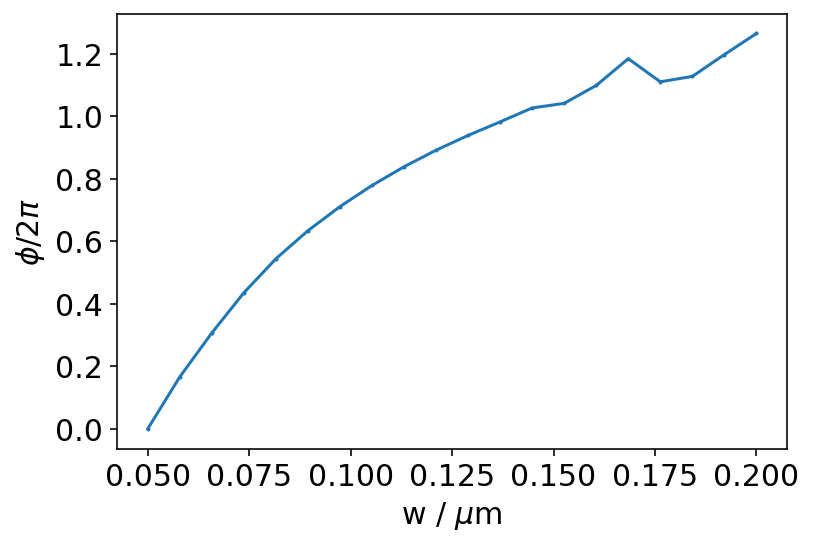

In [120]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [122]:
print(simulation_parameters['sim_id'])
pickle.dump({'post_widths':post_widths,'phases': phases,
             'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

1653001322


### MEEP - run

In [123]:
sim_fname =  '/Users/juan/ZiaLab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [134]:
metalenses = {}
s_time = int(time.time())
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25, # half-width of metalens
    'f': 100., # focal length of metalens
    's': 1, # distance from source to bottom of posts
    'b': 1, # distance from top of posts to sensor
    'gap_v': 1.0, # gap between bottom PML and source, and between field sensor and PML
    'unit_cell_size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 60.,
    'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': False,
    'quiet': False,
    'freq_multiplier': 3, # must be an odd integer
    'log_to_pkl': [False,''],
    }


In [135]:
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)

In [136]:
metalens = simulate_metalens(metalens)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00144982 s
Working in 2D dimensions.
Computational cell is 52 x 6.8 x 0 with resolution 60
     block, center = (0,-1.9,0)
          size (52,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.66278,5.66278,5.66278)
     block, center = (-24.75,1.11022e-16,0)
          size (0.05,0.8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.66278,5.66278,5.66278)
     block, center = (-24.5,1.11022e-16,0)
          size (0.0571137,0.8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.66278,5.66278,5.66278)
     block, center = (-24.25,1.11022e-16,0)
          size (0.0652839,0.8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.66278,5.66278,5.66278)
     block, center = (-24,1.11022e-16,0)
          size (0.0743379,0.8,0)
          axes (1,

/Users/juan/opt/anaconda3/envs/mp/lib/python3.10/site-packages/meep/simulation.py:5426: RuntimeWarning: quiet has been deprecated; use the Verbosity class instead
  warnings.warn("quiet has been deprecated; use the Verbosity class instead", RuntimeWarning)


time for set_epsilon = 3.93672 s
-----------
Meep: using complex fields.
Meep progress: 3.3666666666666667/69.63992833832238 = 4.8% done in 4.0s, 78.8s to go
on time step 404 (time=3.36667), 0.00990997 s/step
Meep progress: 6.991666666666666/69.63992833832238 = 10.0% done in 8.0s, 71.7s to go
on time step 839 (time=6.99167), 0.00919703 s/step
Meep progress: 10.633333333333333/69.63992833832238 = 15.3% done in 12.0s, 66.7s to go
on time step 1276 (time=10.6333), 0.00917264 s/step
Meep progress: 14.283333333333333/69.63992833832238 = 20.5% done in 16.0s, 62.1s to go
on time step 1714 (time=14.2833), 0.00914997 s/step
Meep progress: 17.883333333333333/69.63992833832238 = 25.7% done in 20.0s, 58.0s to go
on time step 2146 (time=17.8833), 0.00926737 s/step
Meep progress: 21.466666666666665/69.63992833832238 = 30.8% done in 24.0s, 53.9s to go
on time step 2576 (time=21.4667), 0.00931117 s/step
Meep progress: 25.075/69.63992833832238 = 36.0% done in 28.0s, 49.8s to go
on time step 3009 (time=

In [137]:
metalens = compute_post_simulation_params(metalens)

Computing the farfield for Ex...
Computing the farfield for Ey...
Computing the farfield for Hz...
Patching the entire field for Ex...
Patching the entire field for Ey...
Patching the entire field for Hz...
Patching the entire field for rho_em...


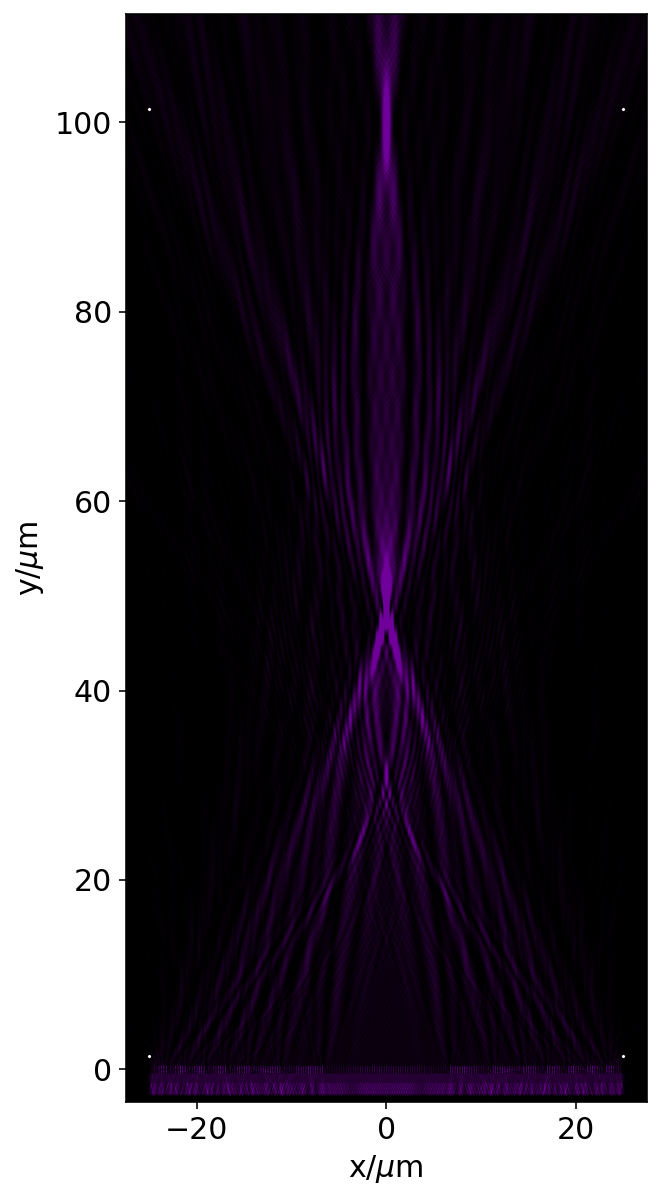

In [138]:
this_field = np.abs(metalens['farfields']['rho_em'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),99.9)
plt.figure(figsize=(10,10))
plt.imshow(this_field,
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['R'], metalens['R']],
         [metalens['detector_plane_coord']]*2,
         'wx',
         ms=1)
plt.plot([-metalens['R'], metalens['R']],
         [metalens['detector_plane_coord']+metalens['f']]*2,
         'wx',
         ms=1)
plt.xlim(-1.1*metalens['R'],1.1*metalens['R'])# 
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.show()

## y-dipole

### S4 - bootstrap

In [172]:
simulation_parameters = {
                        'wavelength': 0.400,
                        'post_width': 0.075,
                        'post_height': 0.800,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 1, 'p_amp': 0}
simulation_parameters = expand_sim_params(simulation_parameters)

In [173]:
results = post_phase(simulation_parameters)

In [174]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Eyi, Eyr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

0.13839353236616211


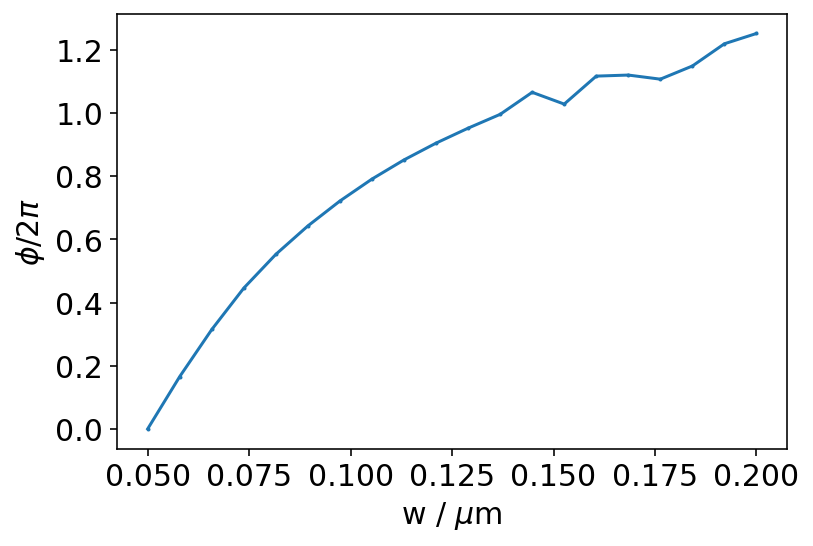

In [175]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [176]:
print(simulation_parameters['sim_id'])
pickle.dump({'post_widths':post_widths,'phases': phases,
             'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

1586985326


### MEEP - run

In [177]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [178]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 0.0,
    'H': 10., # depth of emitter
    'gap_h': 1.0,
    'gap_v': 0.,
    'b': 2.0, # distance between source and interface
    'w': 50.,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 40.,
    'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True,
    'quiet': True,
    'freq_multiplier': 3, # must be an odd integer
    'log_to_pkl': [True,''],
    'NAf': 0.5,
    'beta': np.pi/2
    }
if 'NAf' in metalens.keys():
    metalens['n'] = np.sqrt(metalens['epsilon'])
    metalens['Ω'] = (metalens['wavelength']/2/metalens['unit cell size']
                     + metalens['NAf']) / metalens['n']
    metalens['R'] = metalens['H']*metalens['Ω']/np.sqrt(1-metalens['Ω']**2)
    metalens['zeta'] = np.arcsin(metalens['NAf'])
    metalens['d'] = np.tan(metalens['zeta']) * (metalens['w']-metalens['R'])
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)
metalens['incident_flux'] = get_flux_on_metalens(metalens)
metalens = simulate_metalens(metalens)

/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-1586985334.pkl


In [179]:
metalens = compute_post_simulation_params(metalens)

Computing the farfield for Ex...
Computing the farfield for Ey...
Computing the farfield for Hz...
Patching the entire field for Ex...
Patching the entire field for Ey...
Patching the entire field for Hz...
Patching the entire field for rho_em...


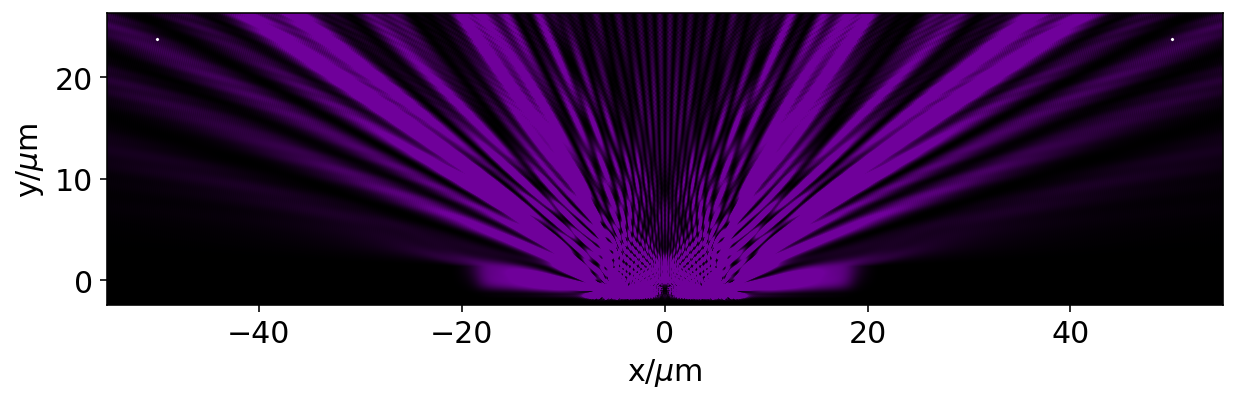

In [180]:
this_field = np.abs(metalens['farfields']['rho_em'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_field,
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wx',
         ms=1)
plt.xlim(-1.1*metalens['w'],1.1*metalens['w'])
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.show()

In [181]:
print_params(metalens)

-----------------------------  -----------------------
post_height                    0.80
R                              6.38
d                              25.18
s                              0.00
H                              10.00
gap_h                          1.00
gap_v                          0.00
b                              2.00
w                              50.00
unit cell size                 0.25
epsilon                        5.84
wavelength                     0.40
min_width                      0.05
pml_width                      1.00
resolution                     40.00
sim_id                         1586985334
complex_fields                 True
save_output                    False
x_mirror_symmetry              True
quiet                          True
freq_multiplier                3
NAf                            0.50
beta                           1.57
n                              2.42
Ω                              0.54
zeta                           1.14
a

## x-dipole

### S4 - bootstrap

In [162]:
simulation_parameters = {
                        'wavelength': 0.400,
                        'post_width': 0.075,
                        'post_height': 0.800,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 1, 'p_amp': 0}
simulation_parameters = expand_sim_params(simulation_parameters)

In [163]:
results = post_phase(simulation_parameters)

In [164]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Eyi, Eyr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

0.13839353236616211


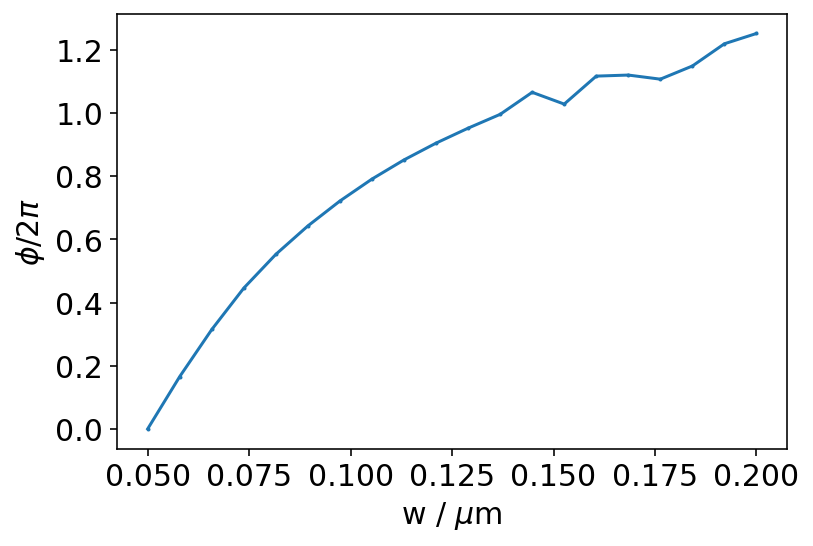

In [165]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [166]:
print(simulation_parameters['sim_id'])
pickle.dump({'post_widths':post_widths,'phases': phases,
             'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

1586983539


### MEEP - run

In [167]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [168]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 0.0,
    'H': 10, # depth of emitter
    'gap_h': 1.0,
    'gap_v': 0.,
    'b': 2.0, # distance between source and interface
    'w': 50.,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 40.,
    'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True,
    'quiet': True,
    'freq_multiplier': 3, # must be an odd integer
    'log_to_pkl': [True,''],
    'NAf': 0.5,
    'beta': 0.
    }
if 'NAf' in metalens.keys():
    metalens['n'] = np.sqrt(metalens['epsilon'])
    metalens['Ω'] = (metalens['wavelength']/2/metalens['unit cell size']
                     + metalens['NAf']) / metalens['n']
    metalens['R'] = metalens['H']*metalens['Ω']/np.sqrt(1-metalens['Ω']**2)
    metalens['zeta'] = np.arcsin(metalens['NAf'])
    metalens['d'] = np.tan(metalens['zeta']) * (metalens['w']-metalens['R'])
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)
metalens['incident_flux'] = get_flux_on_metalens(metalens)
metalens = simulate_metalens(metalens)

/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-1586983548.pkl


In [169]:
metalens = compute_post_simulation_params(metalens)

Computing the farfield for Ex...
Computing the farfield for Ey...
Computing the farfield for Hz...
Patching the entire field for Ex...
Patching the entire field for Ey...
Patching the entire field for Hz...
Patching the entire field for rho_em...


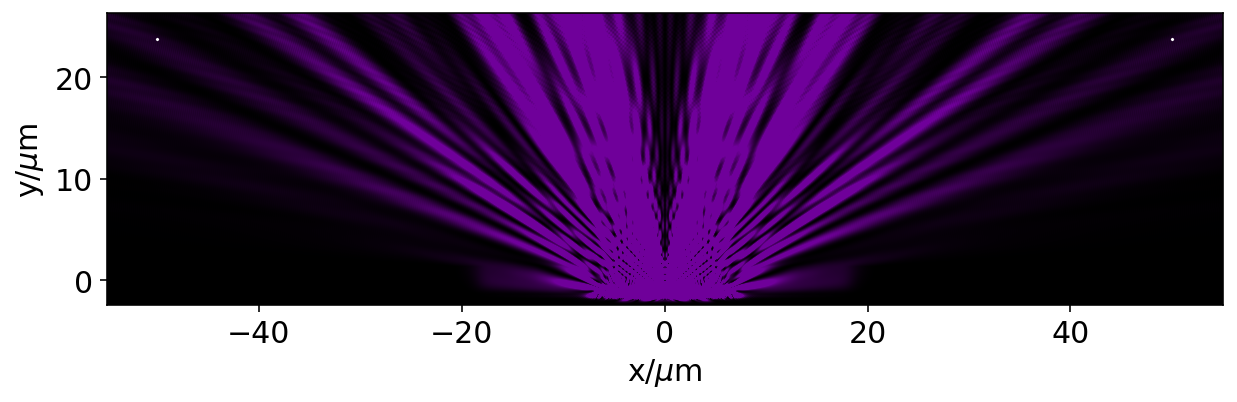

In [170]:
this_field = np.abs(metalens['farfields']['rho_em'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_field,
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wx',
         ms=1)
plt.xlim(-1.1*metalens['w'],1.1*metalens['w'])
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.show()

In [171]:
print_params(metalens)

-----------------------------  -----------------------
post_height                    0.80
R                              6.38
d                              25.18
s                              0.00
H                              10
gap_h                          1.00
gap_v                          0.00
b                              2.00
w                              50.00
unit cell size                 0.25
epsilon                        5.84
wavelength                     0.40
min_width                      0.05
pml_width                      1.00
resolution                     40.00
sim_id                         1586983548
complex_fields                 True
save_output                    False
x_mirror_symmetry              True
quiet                          True
freq_multiplier                3
NAf                            0.50
beta                           0.00
n                              2.42
Ω                              0.54
zeta                           1.14
aper

# 2D dipoles equivalent currents

## In-plane dipole, the right way

In [5]:
def in_plane_dip_amp_func_Ex(metalens):
    '''
    returns the required amplitude function necessary to the z
    component of the electric current necessary to produce the fields
    of an in-plane dipole at an angle beta with respect to the
    x-axis
    '''
    def far_JEx(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        x = mpvec.x
        H, k, n = metalens['H'], metalens['k'], metalens['n']
        bet = metalens['beta']
        return k*n*(H*np.cos(bet) - x*np.sin(bet))*(2*k*np.sqrt(H**2 + x**2) - 1j)*np.exp(1j*k*np.sqrt(H**2 + x**2))/(2*(k*np.sqrt(H**2 + x**2))**(5/2))
    return far_JEx
def in_plane_dip_amp_func_Hz(metalens):
    '''
    returns the required amplitude function necessary to the z
    component of the magnetic current necessary to produce the fields
    of an in-plane dipole at an angle beta with respect to the
    x-axis
    '''
    def far_JHz(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        x = mpvec.x
        H, k, n = metalens['H'], metalens['k'], metalens['n']
        bet = metalens['beta']
        return -H*(H*np.cos(bet) - x*np.sin(bet))*np.exp(1j*k*np.sqrt(H**2 + x**2))/(np.sqrt(k*np.sqrt(H**2 + x**2))*(H**2 + x**2))
    return far_JHz

In [65]:
metalens = {
    'sim_cell_width': 30,
    'wavelength': 1.0,
    'sim_cell_height': 30,
    'pml_width': 1.,
    'source_width': 0.,
    'epsilon': 2.0,
    'complex_fields': True,
    'resolution': 30.,
    'quiet': False,
    'eta': 0.,
    'H': 3.,
    's': 0,
    'ws': 5,
    'beta': np.pi/2.
}
metalens['n'] = np.sqrt(metalens['epsilon'])
metalens['k'] = metalens['n']*2*np.pi/metalens['wavelength']
metalens['simulation_time'] = metalens['sim_cell_height']*metalens['n']/2*np.sqrt(2)
metalens['geometry'] = (
    [mp.Block(size = mp.Vector3(metalens['sim_cell_width'],
                                metalens['sim_cell_height']),
              center = mp.Vector3(0,0),
              material = mp.Medium(epsilon = metalens['epsilon']))])
# Setup the MEEP objects
cell = mp.Vector3(metalens['sim_cell_width'], metalens['sim_cell_height'])
# All around the simulation cell
pml_layers = [ mp.PML(metalens['pml_width']) ]
# Set up the sources
sources = [mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
              component=mp.Ex,
              amp_func=in_plane_dip_amp_func_Ex(metalens),
              center=mp.Vector3(0, 0.),
              size=mp.Vector3(metalens['sim_cell_width'], 0)),
           mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
              component=mp.Hz,
              amp_func=in_plane_dip_amp_func_Hz(metalens),
              center=mp.Vector3(0, 0.),
              size=mp.Vector3(metalens['sim_cell_width'], 0))
          ]
# Set up the symmetries
syms = []
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=metalens['geometry'],
            force_complex_fields=metalens['complex_fields'],
            symmetries=syms,
            sources=sources,
            resolution=metalens['resolution'])
start_time = time.time()
metalens['run_date'] = (datetime.
                        datetime.
                        now().
                        strftime("%b %d %Y at %H:%M:%S"))
mp.quiet(metalens['quiet'])
sim.init_sim()

# Branch if saving for making an animation
sim.run(until=metalens['simulation_time']) 

# Compute the clock run time and grab the fields
metalens['array_metadata'] = sim.get_array_metadata()
metalens['x_axis'] = np.array(metalens['array_metadata'][0])
metalens['y_axis'] = np.array(metalens['array_metadata'][1])
metalens['run_time_in_s'] = time.time() - start_time
metalens['fields'] = {'Ex': sim.get_array(component=mp.Ex).transpose(),
                      'Ey': sim.get_array(component=mp.Ey).transpose(),
                      'Ez': sim.get_array(component=mp.Ez).transpose(),
                      'Hx': sim.get_array(component=mp.Hx).transpose(),
                      'Hy': sim.get_array(component=mp.Hy).transpose(),
                      'Hz': sim.get_array(component=mp.Hz).transpose()
                      }
metalens['eps'] = sim.get_epsilon().transpose()
metalens['fields']['Sx'] = np.real(np.conjugate(metalens['fields']['Ey'])
                            * metalens['fields']['Hz']
                            - np.conjugate(metalens['fields']['Ez'])
                            * metalens['fields']['Hx'])
metalens['fields']['Sy'] = np.real(np.conjugate(metalens['fields']['Ez'])
                      * metalens['fields']['Hx']
                      -np.conjugate(metalens['fields']['Ex'])
                      * metalens['fields']['Hz'])
metalens['fields']['Sr'] = np.sqrt(metalens['fields']['Sx']**2+
                                  metalens['fields']['Sy']**2)
metalens['extent'] = [min(metalens['x_axis']),
                max(metalens['x_axis']),
                min(metalens['y_axis']),
                max(metalens['y_axis'])]

-----------
Initializing structure...
     block, center = (0,0,0)
          size (30,30,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep: using complex fields.
Meep progress: 5.983333333333333/30.000000000000004 = 19.9% done in 4.0s, 16.1s to go
Meep progress: 10.816666666666666/30.000000000000004 = 36.1% done in 8.0s, 14.2s to go
Meep progress: 16.9/30.000000000000004 = 56.3% done in 12.0s, 9.3s to go
Meep progress: 22.966666666666665/30.000000000000004 = 76.6% done in 16.0s, 4.9s to go
Meep progress: 29.03333333333333/30.000000000000004 = 96.8% done in 20.0s, 0.7s to go
run 0 finished at t = 30.016666666666666 (1801 timesteps)


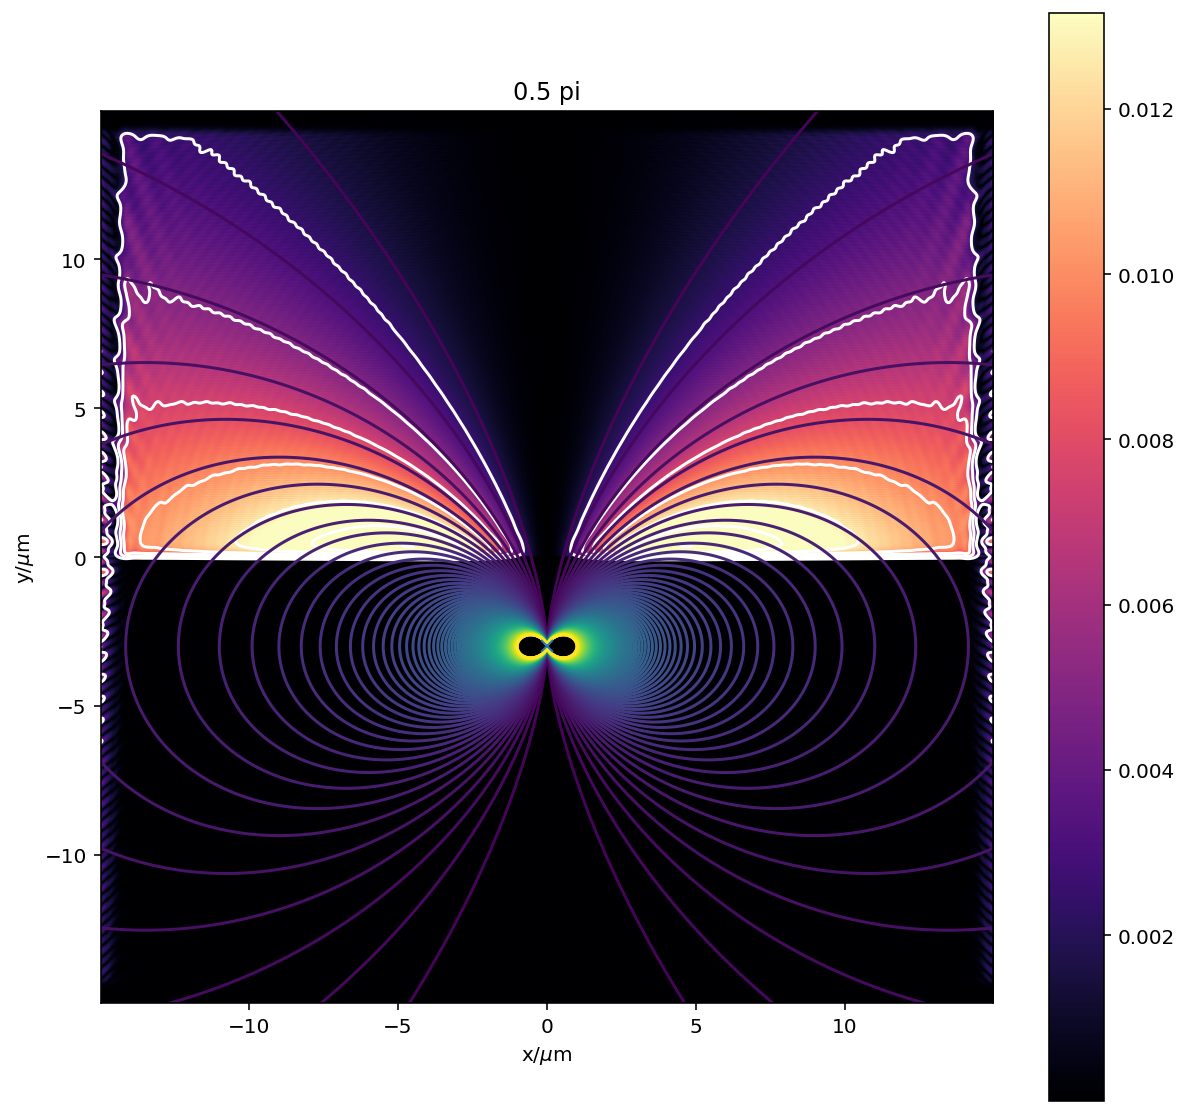

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
this_field = np.real(np.copy(metalens['fields']['Sr']))
X, Y = np.meshgrid(metalens['x_axis'], metalens['y_axis'])
R = np.sqrt(X**2+(Y+metalens['H'])**2)
theta = np.arctan2(Y+metalens['H'],X)
dipole = np.sin(theta-metalens['beta'])**2/R
# dipole[Y<0] = np.nan

vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),98)
im = ax.imshow(this_field,
          origin='lower',
          cmap='magma',
          norm=Normalize(vmin=vmin, vmax=vmax),
         extent=metalens['extent'])
ax.contour(gaussian_filter(this_field,3),
           extent=metalens['extent'],
           levels=np.linspace(0,0.25,100),
           colors='white'
          )
ax.contour(dipole,
           extent=metalens['extent'],
           levels=np.linspace(0,1,100)
          )
ax.set_xlabel('x/$\mu$m')
ax.set_ylabel('y/$\mu$m')
# ax.plot([*metalens['extent'][:2]],[metalens['H']]*2,'w--')
ax.plot([0],[-metalens['H']],'x')
fig.colorbar(im)
ax.set_title('{beta} pi'.format(beta=metalens['beta']/np.pi))
plt.show()

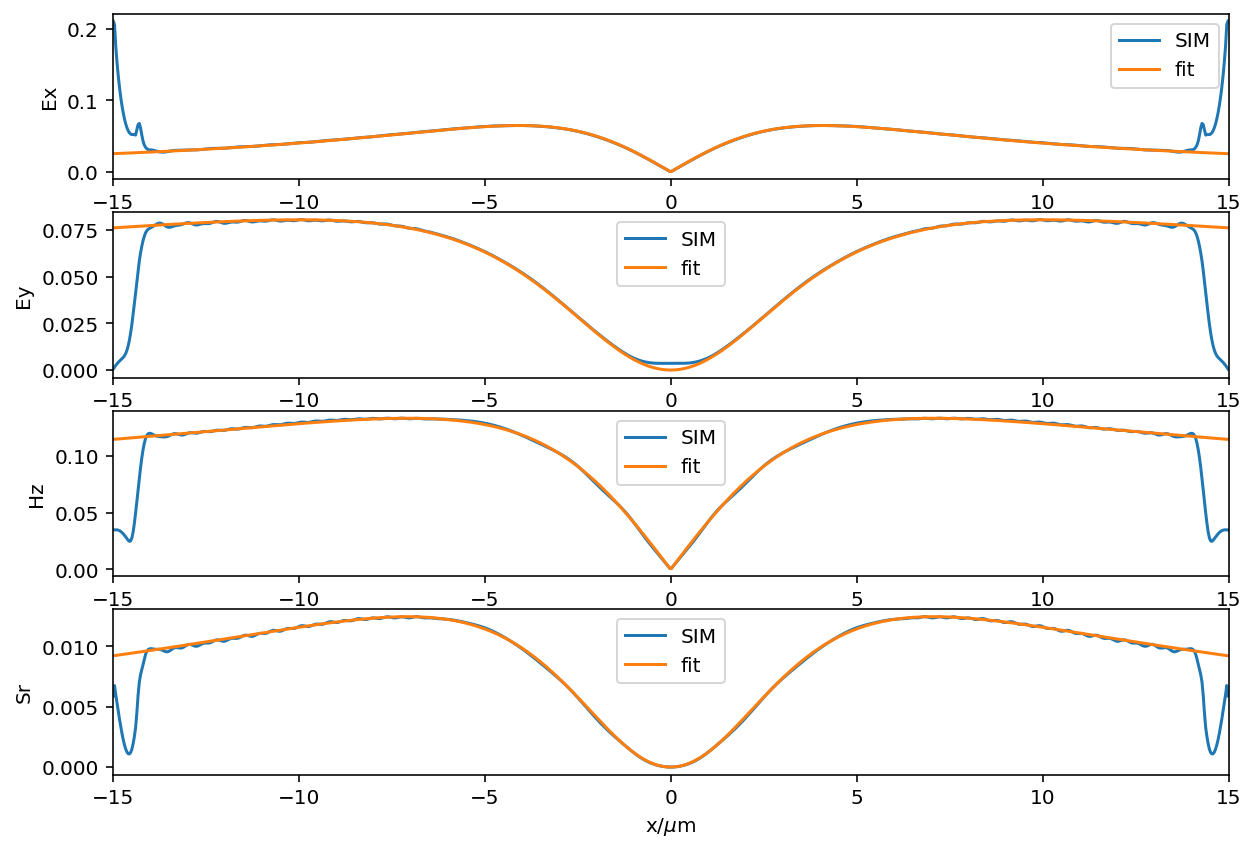

In [67]:
s = 2
middle_index = np.argmin(np.abs(metalens['y_axis']-s))
r = np.sqrt((metalens['H']+s)**2 + metalens['x_axis']**2)
angs = np.arctan2(metalens['H']+s,metalens['x_axis'])

fields = ['Ex','Ey','Hz','Sr']
fig, axes = plt.subplots(nrows=len(fields),figsize=(10,7))
powwow = 0.5

for field, axis in zip(fields, axes):
    simField = np.abs(metalens['fields'][field][middle_index])
    axis.plot(metalens['x_axis'],
              simField,
              label='SIM')
    powwow = 0.5
    if field == 'Hz':
        Hprime = metalens['k']*metalens['x_axis']*(2*metalens['k']*np.sqrt(metalens['x_axis']**2 + (metalens['H'] + s)**2) - 1j)/(2*(metalens['k']*np.sqrt(metalens['x_axis']**2 + (metalens['H'] + s)**2))**(5/2))
        Hprime = np.abs(Hprime)
        c_factors = np.linspace(0,10,1000)
        diffs = [np.sum(np.abs(c*Hprime-simField)) for c in c_factors]
        diffs = np.array(diffs)
        c_opt = c_factors[np.argmin(diffs)]
        axis.plot(metalens['x_axis'],
                  Hprime*c_opt,
                  label='fit')
    elif field == 'Ex':
        Hprime = metalens['x_axis']*(metalens['H'] + s)/(np.sqrt(metalens['k']*np.sqrt(metalens['x_axis']**2 + (metalens['H'] + s)**2))*(metalens['x_axis']**2 + (metalens['H'] + s)**2))
        Hprime = np.abs(Hprime)
        c_factors = np.linspace(0,10,1000)
        diffs = [np.sum(np.abs(c*Hprime-simField)) for c in c_factors]
        diffs = np.array(diffs)
        c_opt = c_factors[np.argmin(diffs)]
        axis.plot(metalens['x_axis'],
                  Hprime*c_opt,
                  label='fit')
    elif field == 'Ey':
        Hprime = metalens['x_axis']**2/(np.sqrt(metalens['k']*np.sqrt(metalens['x_axis']**2 + (metalens['H'] + s)**2))*(metalens['x_axis']**2 + (metalens['H'] + s)**2))
        Hprime = np.abs(Hprime)
        c_factors = np.linspace(0,10,1000)
        diffs = [np.sum(np.abs(c*Hprime-simField)) for c in c_factors]
        diffs = np.array(diffs)
        c_opt = c_factors[np.argmin(diffs)]
        axis.plot(metalens['x_axis'],
                  Hprime*c_opt,
                  label='fit')
    elif field == 'Sr':
        powwow = 1
        Hprime = np.abs(1 / r**powwow * np.sin(angs-metalens['beta'])**2)
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='fit')
    axis.set_xlim(-metalens['sim_cell_width']/2,metalens['sim_cell_width']/2)
    axis.legend()
    if field == fields[-1]:
        axis.set_xlabel('x/$\mu$m')
    axis.set_ylabel(field)
plt.show()

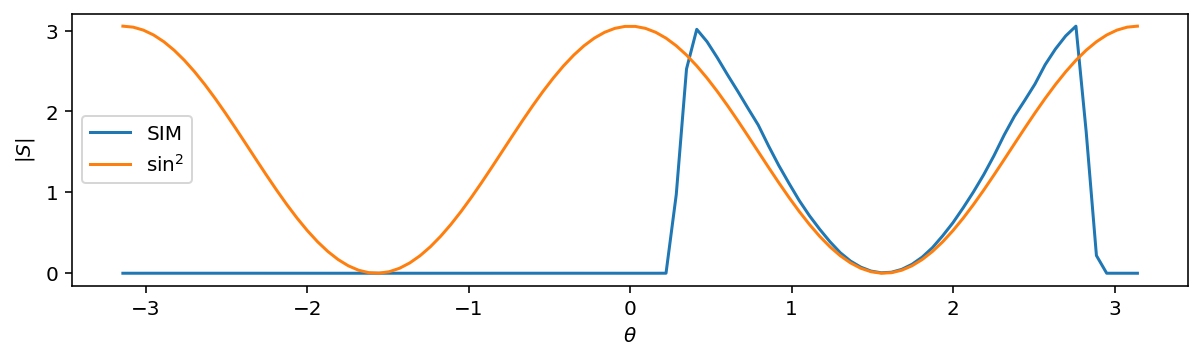

In [68]:
ring_width = 0.1
radius = 10.0
num_angle_slices = 100
this_field = np.copy(metalens['fields']['Sr'])
this_field[~(np.abs(R-radius)<=ring_width)] = np.nan
angles = np.linspace(-np.pi,np.pi,num_angle_slices)
ringo = [np.nansum(this_field[np.abs(theta-th)<=(angles[1]-angles[0])]) for th in angles]
fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot(angles,ringo,label='SIM')
ax.plot(angles,max(ringo)*np.sin(angles-metalens['beta'])**2,
       label='$\sin^2$')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$|S|$')
#plt.xlim(0,np.pi)
ax.legend()
plt.show()

In [30]:
#this_field = np.real(np.copy(metalens['fields']['Sr']))
this_field = np.copy(metalens['fields']['Sr'])
this_field[~(np.abs(R-radius)<=ring_width)] = np.nan
X, Y = np.meshgrid(metalens['x_axis'], metalens['y_axis'])
R = np.sqrt(X**2+(Y+metalens['H'])**2)
theta = np.arctan2(Y+metalens['H'],X)
dipole = np.sin(theta-metalens['beta'])**2/R
# dipole[Y<0] = np.nan

vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),98)
im = ax.imshow(this_field,
          origin='lower',
          cmap='magma',
          norm=Normalize(vmin=vmin, vmax=vmax),
         extent=metalens['extent'])

ax.set_xlabel('x/$\mu$m')
ax.set_ylabel('y/$\mu$m')
# ax.plot([*metalens['extent'][:2]],[metalens['H']]*2,'w--')
ax.plot([0],[-metalens['H']],'x')
fig.colorbar(im)
ax.set_title('{beta} pi'.format(beta=metalens['beta']/np.pi))
plt.show()

## Ez dipole, the right way

In [62]:
def plane_wave_amp_func_Ez(metalens):
    '''
    returns the required amplitude
    function necessary to simulate
    an isotropic point source
    '''
    def far_JEz(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        r = np.sqrt(metalens['H']**2+mpvec.x**2)
        return -((np.exp(1j*metalens['k']*r) * metalens['H']
                *(4*metalens['n']*np.pi*r+1j*metalens['wavelength']))
               /(4*np.pi*r**2.5))
    return far_JEz
def plane_wave_amp_func_Hx(metalens):
    '''
    returns the required amplitude
    function necessary to simulate
    an isotropic point source
    '''
    def far_JBx(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        r = np.sqrt(metalens['H']**2+mpvec.x**2)
        return -((np.exp(1j*metalens['k']*r))/(r**0.5))
    return far_JBx

In [63]:
metalens = {
    'sim_cell_width': 20,
    'wavelength': 1.0,
    'sim_cell_height': 20,
    'pml_width': 1.,
    'source_width': 0.,
    'epsilon': 2.5*2.5,
    'complex_fields': True,
    'resolution': 30.,
    'quiet': False,
    'eta': 0.,
    'H': 3.0,
    's': 0,
    'ws': 5
}
metalens['n'] = np.sqrt(metalens['epsilon'])
metalens['k'] = metalens['n']*2*np.pi/metalens['wavelength']
metalens['simulation_time'] = metalens['sim_cell_height']*metalens['n']/2*np.sqrt(2)
metalens['geometry'] = (
    [mp.Block(size = mp.Vector3(metalens['sim_cell_width'],
                                metalens['sim_cell_height']),
              center = mp.Vector3(0,0),
              material = mp.Medium(epsilon = metalens['epsilon']))])
# Setup the MEEP objects
cell = mp.Vector3(metalens['sim_cell_width'], metalens['sim_cell_height'])
# All around the simulation cell
pml_layers = [ mp.PML(metalens['pml_width']) ]
# Set up the sources
sources = [mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
              component=mp.Ez,
              amp_func=plane_wave_amp_func_Ez(metalens),
              center=mp.Vector3(0, 0.),
              size=mp.Vector3(metalens['sim_cell_width'], 0)),
          mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
              component=mp.Hx,
              amp_func=plane_wave_amp_func_Hx(metalens),      
              center=mp.Vector3(0, 0),
              size=mp.Vector3(metalens['sim_cell_width'], 0))
          ]
# Set up the symmetries
syms = []
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=metalens['geometry'],
            force_complex_fields=metalens['complex_fields'],
            symmetries=syms,
            sources=sources,
            resolution=metalens['resolution'])
start_time = time.time()
metalens['run_date'] = (datetime.
                        datetime.
                        now().
                        strftime("%b %d %Y at %H:%M:%S"))
mp.quiet(metalens['quiet'])
sim.init_sim()

# Branch if saving for making an animation
sim.run(until=metalens['simulation_time']) 

# Compute the clock run time and grab the fields
metalens['array_metadata'] = sim.get_array_metadata()
metalens['x_axis'] = np.array(metalens['array_metadata'][0])
metalens['y_axis'] = np.array(metalens['array_metadata'][1])
metalens['run_time_in_s'] = time.time() - start_time
metalens['fields'] = {'Ex': sim.get_array(component=mp.Ex).transpose(),
                      'Ey': sim.get_array(component=mp.Ey).transpose(),
                      'Ez': sim.get_array(component=mp.Ez).transpose(),
                      'Hx': sim.get_array(component=mp.Hx).transpose(),
                      'Hy': sim.get_array(component=mp.Hy).transpose(),
                      'Hz': sim.get_array(component=mp.Hz).transpose()
                      }
metalens['eps'] = sim.get_epsilon().transpose()
metalens['fields']['Sx'] = np.real(np.conjugate(metalens['fields']['Ey'])
                            * metalens['fields']['Hz']
                            - np.conjugate(metalens['fields']['Ez'])
                            * metalens['fields']['Hx'])
metalens['fields']['Sy'] = np.real(np.conjugate(metalens['fields']['Ez'])
                      * metalens['fields']['Hx']
                      -np.conjugate(metalens['fields']['Ex'])
                      * metalens['fields']['Hz'])
metalens['fields']['Sr'] = np.sqrt(metalens['fields']['Sx']**2+
                                  metalens['fields']['Sy']**2)
metalens['extent'] = [min(metalens['x_axis']),
                max(metalens['x_axis']),
                min(metalens['y_axis']),
                max(metalens['y_axis'])]

-----------
Initializing structure...
     block, center = (0,0,0)
          size (20,20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep: using complex fields.
Meep progress: 13.7/35.35533905932738 = 38.7% done in 4.0s, 6.3s to go
Meep progress: 30.633333333333333/35.35533905932738 = 86.6% done in 8.0s, 1.2s to go
run 0 finished at t = 35.36666666666667 (2122 timesteps)


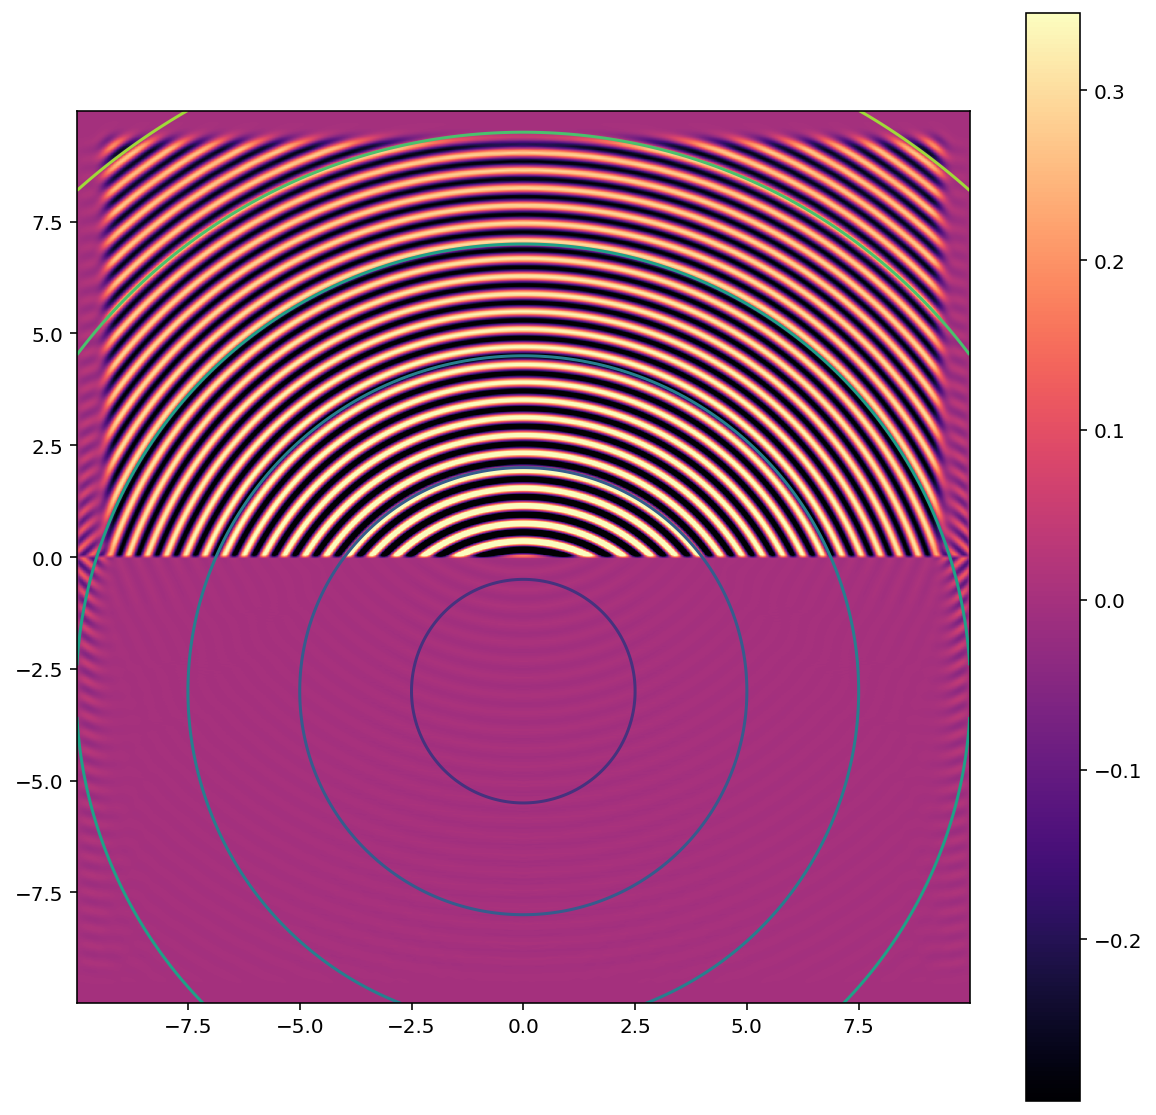

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
this_field = np.real(np.copy(metalens['fields']['Ez']))
X, Y = np.meshgrid(metalens['x_axis'], metalens['y_axis'])
R = np.sqrt(X**2+(Y+metalens['H'])**2)
theta = np.arctan2(Y,X)
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),98)
im = ax.imshow(this_field,
          origin='lower',
          cmap='magma',
          norm=Normalize(vmin=vmin, vmax=vmax),
         extent=metalens['extent'])
ax.contour(R,extent=metalens['extent'])
# ax.plot([*metalens['extent'][:2]],[metalens['H']]*2,'w--')
# ax.plot([-metalens['ws'],metalens['ws']],[metalens['H']]*2,'xw')
fig.colorbar(im)
plt.show()

## Plane waves, the right way

In [86]:
def plane_wave_amp_func_Ez(metalens):
    '''
    returns the required amplitude
    function necessary to simulate
    an isotropic point source
    '''
    def far_JEz(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        return -metalens['n']
    return far_JEz
def plane_wave_amp_func_Hx(metalens):
    '''
    returns the required amplitude
    function necessary to simulate
    an isotropic point source
    '''
    def far_JBx(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        return -1.
    return far_JBx

In [89]:
metalens = {
    'sim_cell_width': 20,
    'wavelength': 1.0,
    'sim_cell_height': 20,
    'pml_width': 1.,
    'source_width': 0.,
    'epsilon': 2.5*2.5,
    'complex_fields': True,
    'resolution': 30.,
    'quiet': False,
    'eta': 0.,
    'H': 3.0,
    's': 0,
    'ws': 5
}
metalens['n'] = np.sqrt(metalens['epsilon'])
metalens['k'] = metalens['n']*2*np.pi/metalens['wavelength']
metalens['simulation_time'] = metalens['sim_cell_height']*metalens['n']/2*np.sqrt(2)
metalens['geometry'] = (
    [mp.Block(size = mp.Vector3(metalens['sim_cell_width'],
                                metalens['sim_cell_height']),
              center = mp.Vector3(0,0),
              material = mp.Medium(epsilon = metalens['epsilon']))])
# Setup the MEEP objects
cell = mp.Vector3(metalens['sim_cell_width'], metalens['sim_cell_height'])
# All around the simulation cell
pml_layers = [ mp.PML(metalens['pml_width']) ]
# Set up the sources
sources = [mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
              component=mp.Ez,
              amplitude=2.5,
              center=mp.Vector3(0, -metalens['H']),
              size=mp.Vector3(metalens['sim_cell_width'], 0)),
          mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
              component=mp.Hx,
              amplitude=1.,
              center=mp.Vector3(0, -metalens['H']),
              size=mp.Vector3(metalens['sim_cell_width'], 0))
          ]
# Set up the symmetries
syms = []
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=metalens['geometry'],
            force_complex_fields=metalens['complex_fields'],
            symmetries=syms,
            sources=sources,
            resolution=metalens['resolution'])
start_time = time.time()
metalens['run_date'] = (datetime.
                        datetime.
                        now().
                        strftime("%b %d %Y at %H:%M:%S"))
mp.quiet(metalens['quiet'])
sim.init_sim()

# Branch if saving for making an animation
sim.run(until=metalens['simulation_time']) 

# Compute the clock run time and grab the fields
metalens['array_metadata'] = sim.get_array_metadata()
metalens['x_axis'] = np.array(metalens['array_metadata'][0])
metalens['y_axis'] = np.array(metalens['array_metadata'][1])
metalens['run_time_in_s'] = time.time() - start_time
metalens['fields'] = {'Ex': sim.get_array(component=mp.Ex).transpose(),
                      'Ey': sim.get_array(component=mp.Ey).transpose(),
                      'Ez': sim.get_array(component=mp.Ez).transpose(),
                      'Hx': sim.get_array(component=mp.Hx).transpose(),
                      'Hy': sim.get_array(component=mp.Hy).transpose(),
                      'Hz': sim.get_array(component=mp.Hz).transpose()
                      }
metalens['eps'] = sim.get_epsilon().transpose()
metalens['fields']['Sx'] = np.real(np.conjugate(metalens['fields']['Ey'])
                            * metalens['fields']['Hz']
                            - np.conjugate(metalens['fields']['Ez'])
                            * metalens['fields']['Hx'])
metalens['fields']['Sy'] = np.real(np.conjugate(metalens['fields']['Ez'])
                      * metalens['fields']['Hx']
                      -np.conjugate(metalens['fields']['Ex'])
                      * metalens['fields']['Hz'])
metalens['fields']['Sr'] = np.sqrt(metalens['fields']['Sx']**2+
                                  metalens['fields']['Sy']**2)
metalens['extent'] = [min(metalens['x_axis']),
                max(metalens['x_axis']),
                min(metalens['y_axis']),
                max(metalens['y_axis'])]

-----------
Initializing structure...
     block, center = (0,0,0)
          size (20,20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep: using complex fields.
Meep progress: 15.366666666666667/35.35533905932738 = 43.5% done in 4.0s, 5.2s to go
Meep progress: 33.9/35.35533905932738 = 95.9% done in 8.0s, 0.3s to go
run 0 finished at t = 35.36666666666667 (2122 timesteps)


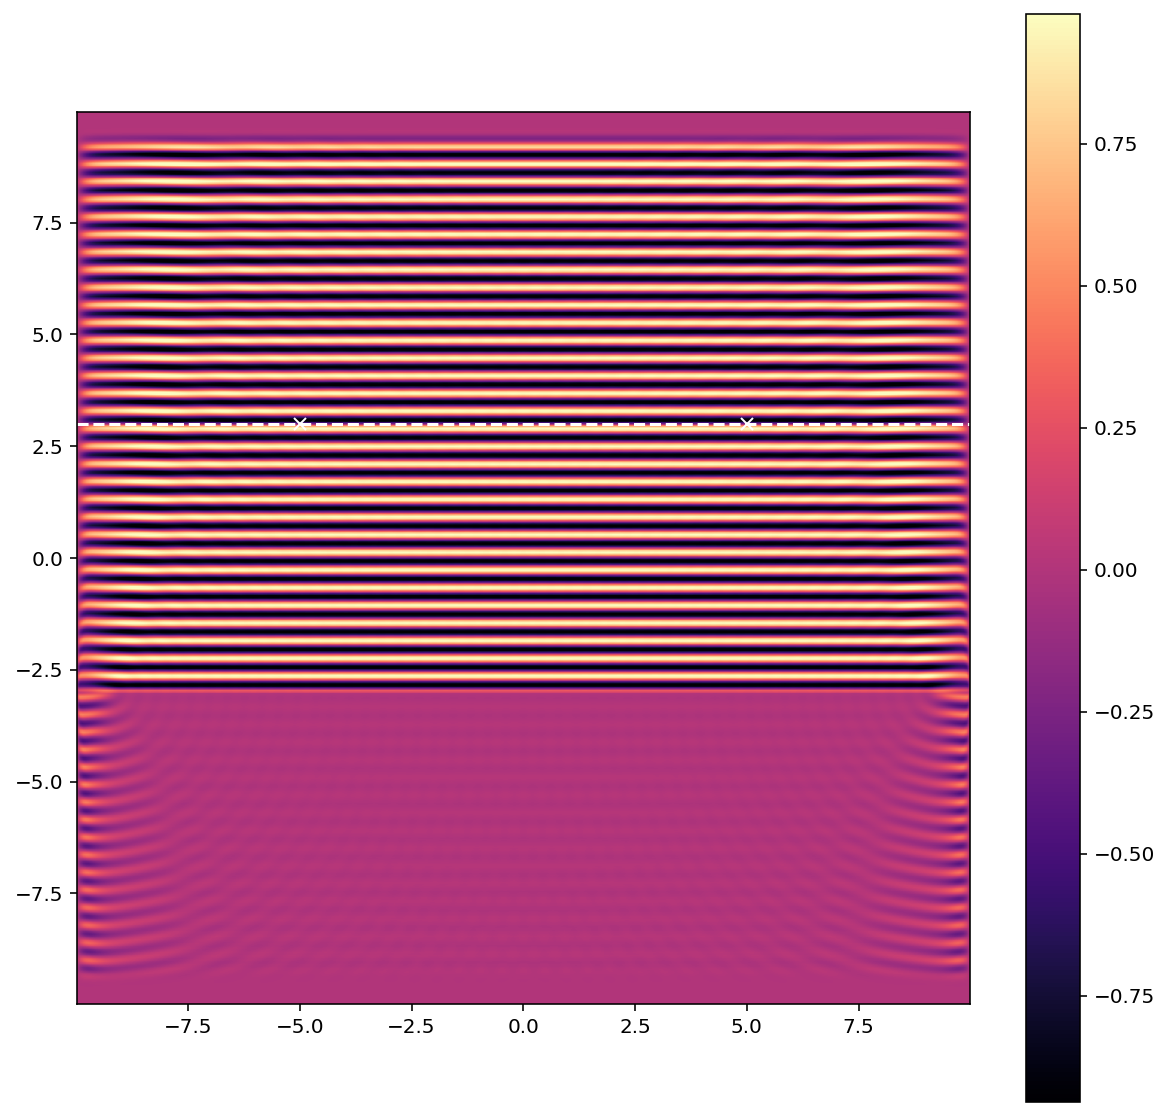

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
this_field = np.real(np.copy(metalens['fields']['Ez']))
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),98)
im = ax.imshow(this_field,
          origin='lower',
          cmap='magma',
          norm=Normalize(vmin=vmin, vmax=vmax),
         extent=metalens['extent'])
ax.plot([*metalens['extent'][:2]],[metalens['H']]*2,'w--')
ax.plot([-metalens['ws'],metalens['ws']],[metalens['H']]*2,'xw')
fig.colorbar(im)
plt.show()

## Ex

In [242]:
metalens = {
    'sim_cell_width': 20,
    'wavelength': 0.49,
    'sim_cell_height': 20,
    'pml_width': 1.,
    'source_width': 0.,
    'epsilon': 1,
    'complex_fields': True,
    'resolution': 20.,
    'quiet': False,
    'eta': 0.,
    'H': 5.0,
    's': 0,
    'ws': 5
}
metalens['n'] = np.sqrt(metalens['epsilon'])
metalens['k'] = metalens['n']*2*np.pi/metalens['wavelength']
metalens['simulation_time'] = metalens['sim_cell_height']*metalens['n']/2*np.sqrt(2)
metalens['geometry'] = (
    [mp.Block(size = mp.Vector3(metalens['sim_cell_width'],
                                metalens['sim_cell_height']),
              center = mp.Vector3(0,0),
              material = mp.Medium(epsilon = metalens['epsilon']))])
# Setup the MEEP objects
cell = mp.Vector3(metalens['sim_cell_width'], metalens['sim_cell_height'])
# All around the simulation cell
pml_layers = [ mp.PML(metalens['pml_width']) ]
# Set up the sources
sources = [mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
          component=mp.Ex,
          amplitude=np.cos(metalens['eta']),
          center=mp.Vector3(0, 0),
          size=mp.Vector3(0, 0)),
#           mp.Source(src=mp.ContinuousSource(
#                      wavelength=metalens['wavelength'],
#                      width=metalens['source_width']
#                     ),
#           component=mp.Ey,
#           amplitude=np.sin(metalens['eta']),
#           center=mp.Vector3(0, 0),
#           size=mp.Vector3(0, 0))
          ]
# Set up the symmetries
syms = []
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=metalens['geometry'],
            force_complex_fields=metalens['complex_fields'],
            symmetries=syms,
            sources=sources,
            resolution=metalens['resolution'])
start_time = time.time()
metalens['run_date'] = (datetime.
                        datetime.
                        now().
                        strftime("%b %d %Y at %H:%M:%S"))
mp.quiet(metalens['quiet'])
sim.init_sim()

# Branch if saving for making an animation
sim.run(until=metalens['simulation_time']) 

# Compute the clock run time and grab the fields
metalens['array_metadata'] = sim.get_array_metadata()
metalens['x_axis'] = np.array(metalens['array_metadata'][0])
metalens['y_axis'] = np.array(metalens['array_metadata'][1])
metalens['run_time_in_s'] = time.time() - start_time
metalens['fields'] = {'Ex': sim.get_array(component=mp.Ex).transpose(),
                      'Ey': sim.get_array(component=mp.Ey).transpose(),
                      'Hz': sim.get_array(component=mp.Hz).transpose()
                      }
metalens['eps'] = sim.get_epsilon().transpose()
metalens['fields']['Sx'] = np.real(np.conjugate(metalens['fields']['Ey'])
                            * metalens['fields']['Hz'])
metalens['fields']['Sy'] = np.real(-np.conjugate(metalens['fields']['Ex'])
                      * metalens['fields']['Hz'])
metalens['fields']['Sr'] = np.sqrt(metalens['fields']['Sx']**2+
                                  metalens['fields']['Sy']**2)
metalens['extent'] = [min(metalens['x_axis']),
                max(metalens['x_axis']),
                min(metalens['y_axis']),
                max(metalens['y_axis'])]

-----------
Initializing structure...
     block, center = (0,0,0)
          size (20,20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep: using complex fields.
run 0 finished at t = 14.15 (566 timesteps)


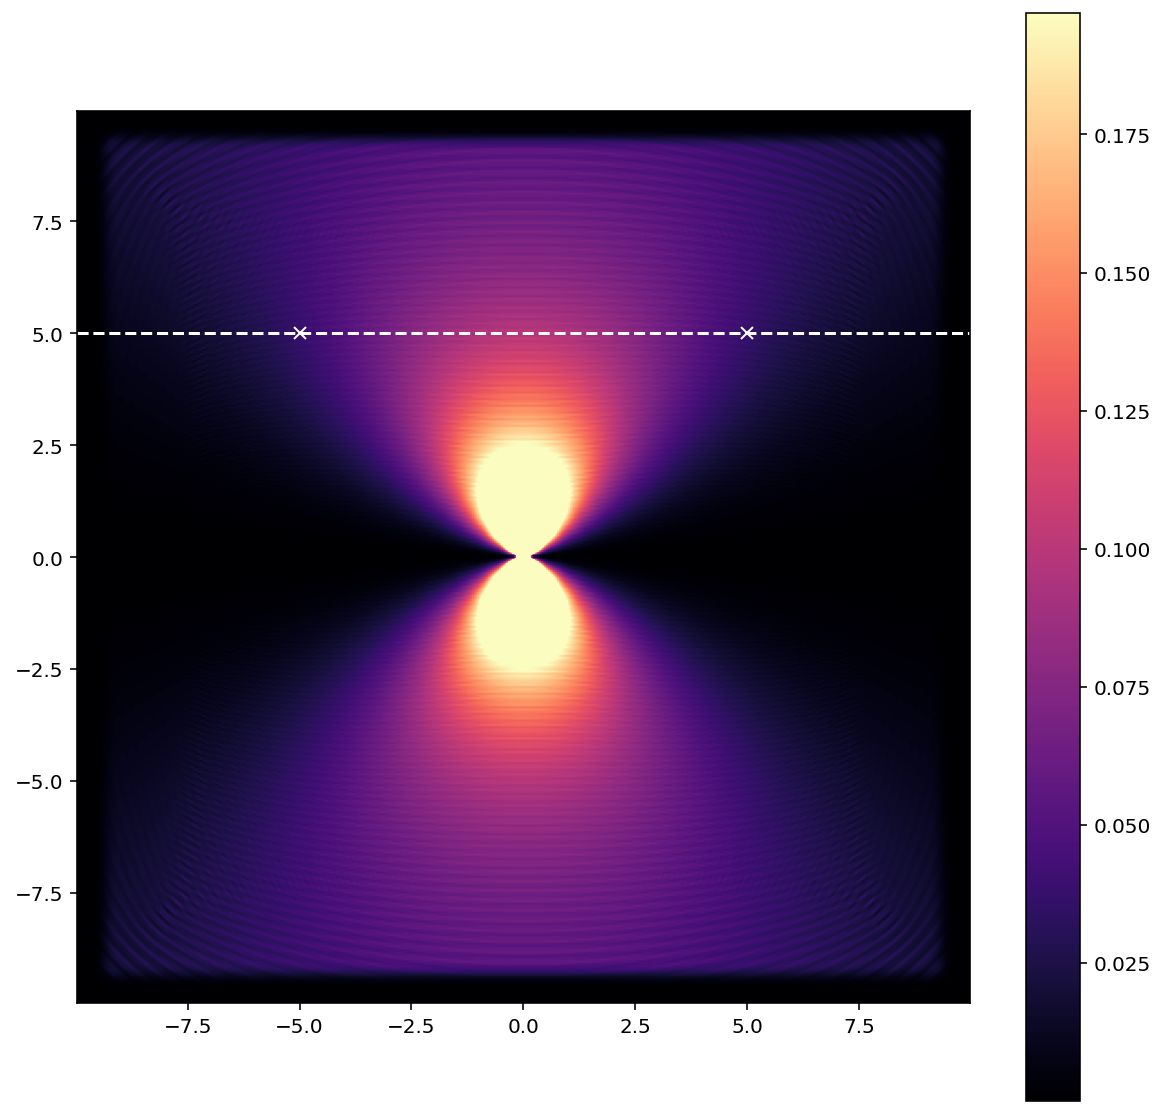

In [243]:
X, Y = np.meshgrid(metalens['x_axis'], metalens['y_axis'])
R = np.sqrt(X**2+Y**2)
theta = np.arctan2(Y,X)
fig, ax = plt.subplots(figsize=(10,10))
this_field = np.copy(metalens['fields']['Sr'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),98)
im = ax.imshow(this_field,
          origin='lower',
          cmap='magma',
          norm=Normalize(vmin=vmin, vmax=vmax),
         extent=metalens['extent'])
ax.plot([*metalens['extent'][:2]],[metalens['H']]*2,'w--')
ax.plot([-metalens['ws'],metalens['ws']],[metalens['H']]*2,'xw')
fig.colorbar(im)
plt.show()

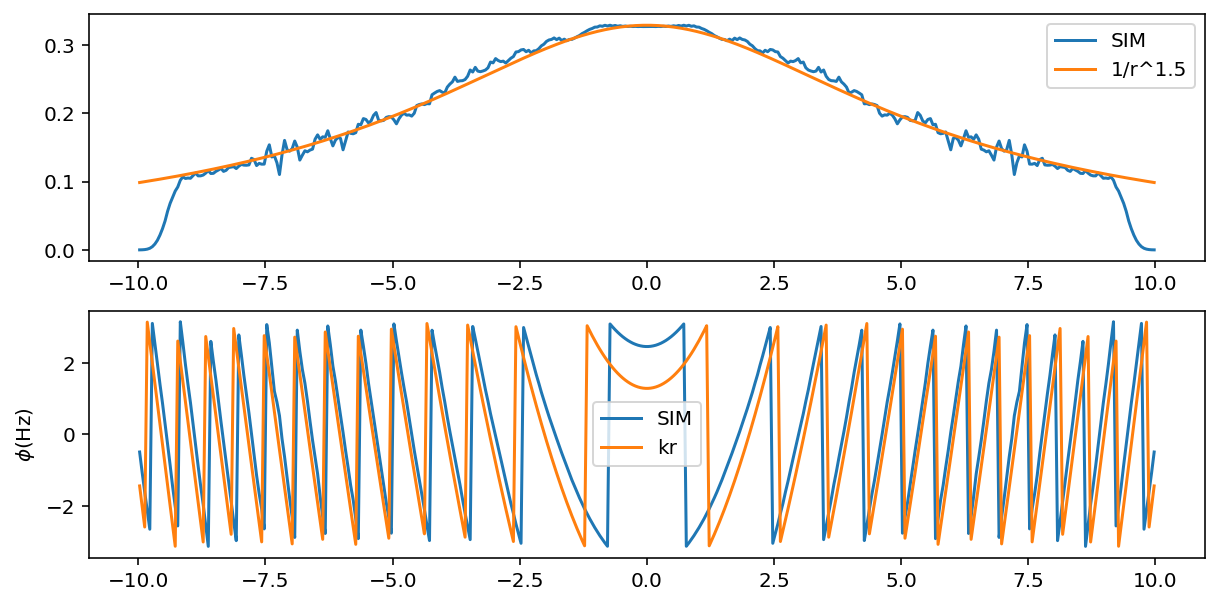

In [244]:
this_field = np.copy(metalens['fields']['Hz'])
H_index = np.argmin(np.abs(metalens['y_axis']-metalens['H']))
fig, axes = plt.subplots(nrows=2,figsize=(10,5))
r = np.sqrt(metalens['H']**2+metalens['x_axis']**2)
powwow = 1.5
rpow = 1/r**powwow
rpow = rpow/max(rpow)
x_angle = np.arctan2(metalens['H'],metalens['x_axis'])
axes[0].plot(metalens['x_axis'], np.abs(this_field[H_index]),
        label='SIM')
axes[0].plot(metalens['x_axis'],np.max(np.abs(this_field[H_index]))*rpow, label='1/r^%.1f' % powwow)
axes[0].legend()
axes[1].plot(metalens['x_axis'], np.angle(this_field[H_index]),
        label='SIM')
axes[1].plot(metalens['x_axis'],np.angle(np.exp(1j*metalens['k']*r)), label='kr')
axes[1].legend()
axes[1].set_ylabel('$\phi$(Hz)')
plt.show()

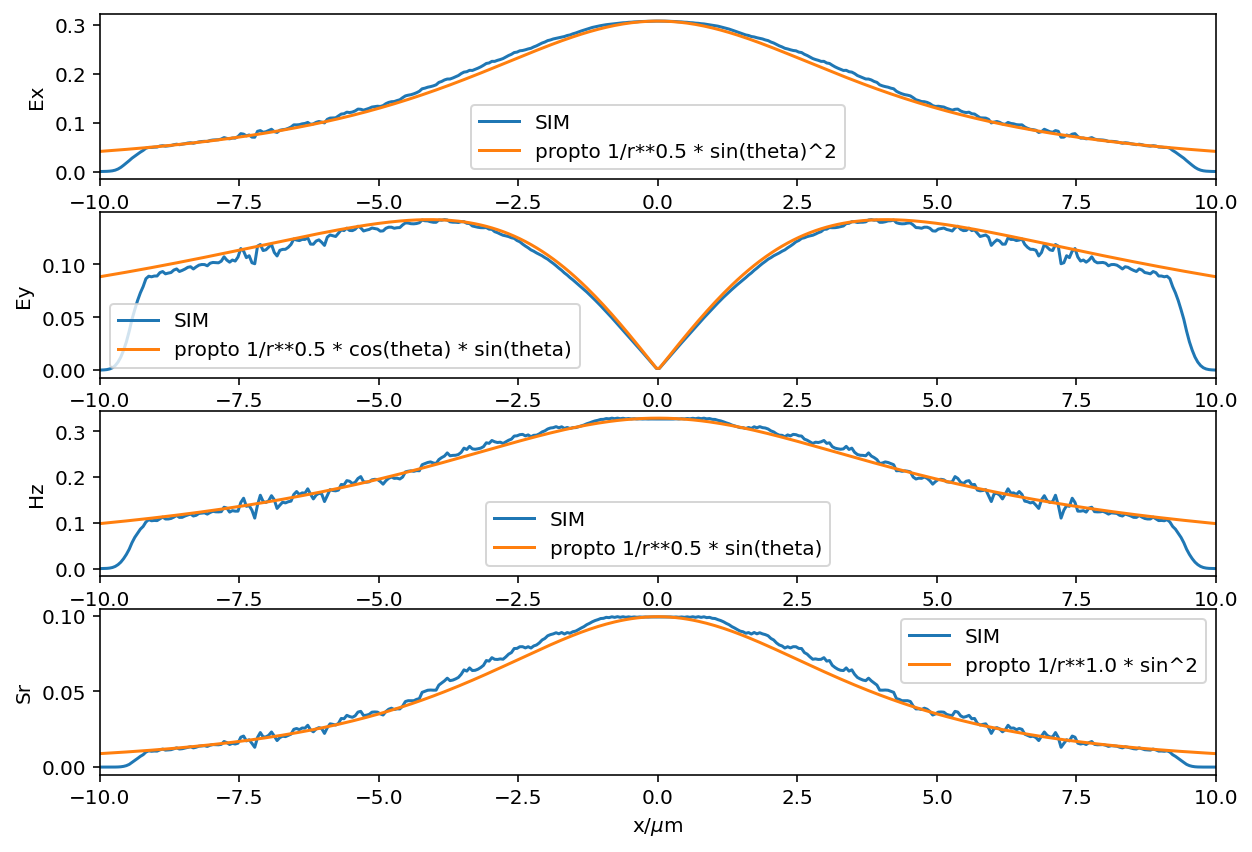

In [245]:
middle_index = np.argmin(np.abs(metalens['y_axis']-metalens['H']))
r = np.sqrt(metalens['H']**2 + metalens['x_axis']**2)
angs = np.arctan2(metalens['H'],metalens['x_axis'])

fields = ['Ex','Ey','Hz','Sr']
fig, axes = plt.subplots(nrows=len(fields),figsize=(10,7))
powwow = 0.5

for field, axis in zip(fields, axes):
    simField = np.abs(metalens['fields'][field][middle_index])
    axis.plot(metalens['x_axis'],
              simField,
              label='SIM')
    powwow = 0.5
    if field == 'Hz':
        Hprime = 1 / r**powwow * np.sin(angs)
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='propto 1/r**%.1f * sin(theta)'%powwow)
    elif field == 'Ex':
        Hprime = 1 / r**powwow * np.sin(angs)**2
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='propto 1/r**%.1f * sin(theta)^2'%powwow)
    elif field == 'Ey':
        Hprime = np.abs(1 / r**powwow * np.cos(angs) * np.sin(angs))
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='propto 1/r**%.1f * cos(theta) * sin(theta)'%powwow)
    elif field == 'Sr':
        powwow = 1
        Hprime = np.abs(1 / r**powwow * np.sin(angs)**2)
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='propto 1/r**%.1f * sin^2'%powwow)
    axis.set_xlim(-metalens['sim_cell_width']/2,metalens['sim_cell_width']/2)
    axis.legend()
    if field == fields[-1]:
        axis.set_xlabel('x/$\mu$m')
    axis.set_ylabel(field)
plt.show()

/Users/juan/opt/anaconda3/envs/pmeep/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


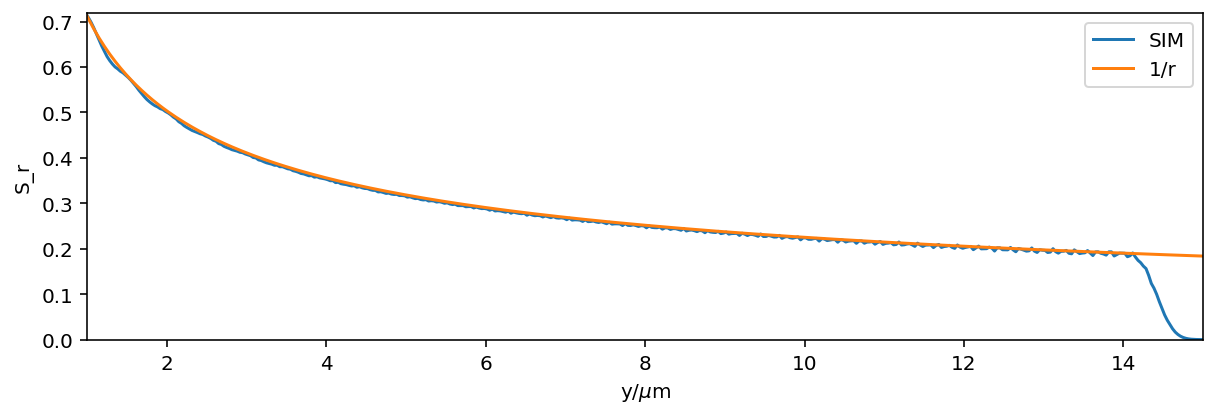

In [218]:
pivot = 1
pivot_index = np.argmin(np.abs(metalens['y_axis']-pivot))
fit = 1/metalens['y_axis']**0.5
fig, ax = plt.subplots(figsize=(10,3))
yslice = metalens['fields']['Ex'][:,int(len(metalens['x_axis'])/2)]
yslice = np.abs(yslice)
ax.plot(metalens['y_axis'],
        yslice,label='SIM')
ax.set_xlabel('y/$\mu$m')
ax.set_ylabel('S_r')
ax.plot(metalens['y_axis'],
        fit/fit[pivot_index]*yslice[pivot_index],
       label='1/r')
ax.legend()
plt.xlim(pivot,metalens['sim_cell_height']/2)
plt.ylim(0,yslice[pivot_index])
plt.show()

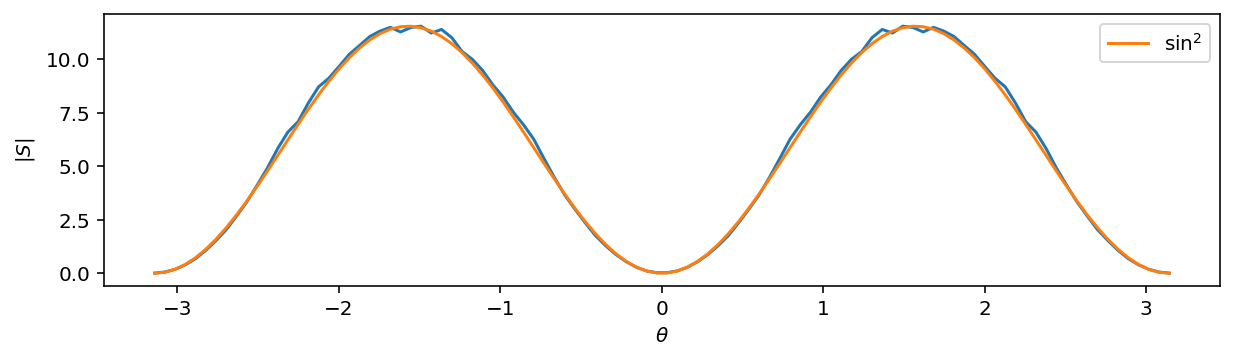

In [219]:
ring_width = 0.1
radius = 5.0
num_angle_slices = 100
this_field = np.copy(metalens['fields']['Sr'])
this_field[~(np.abs(R-radius)<=ring_width)] = np.nan
angles = np.linspace(-np.pi,np.pi,num_angle_slices)
ringo = [np.nansum(this_field[np.abs(theta-th)<=(angles[1]-angles[0])]) for th in angles]
fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot(angles,ringo)
ax.plot(angles,max(ringo)*np.sin(angles-metalens['eta'])**2,
       label='$\sin^2$')
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$|S|$')
ax.legend()
plt.show()

In [233]:
def far_ex_source_amp_func_x(metalens):
    '''
    returns the required amplitude
    function necessary to simulate
    an isotropic point source
    '''
    def far_exx(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        r = np.sqrt(mpvec.x**2 + (metalens['H'] - metalens['s'])**2)
        angle = np.arctan2((metalens['H'] - metalens['s']), mpvec.x)
        ph = np.exp(1j * metalens['k'] * r)
        am = np.sin(angle)**2/r**1.5
        return am * ph
    return far_exx
def far_ex_source_amp_func_y(metalens):
    '''
    returns the required amplitude
    function necessary to simulate
    an isotropic point source
    '''
    def far_exy(mpvec):
        '''
        remember that the vectors
        that MEEP will provide here
        are relative to the center of the source
        '''
        r = np.sqrt(mpvec.x**2 + (metalens['H'] - metalens['s'])**2)
        angle = np.arctan2((metalens['H'] - metalens['s']), mpvec.x)
        ph = np.exp(1j * metalens['k'] * r)
        am = -np.cos(angle)*np.sin(angle)/r**1.5
        return 0.
        return am * ph
    return far_exy

In [234]:
# Set up the sources
sources = [mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
          component=mp.Ex,
          center=mp.Vector3(0, 0),
          size=mp.Vector3(2*metalens['ws'], 0),
          amp_func = far_ex_source_amp_func_x(metalens)
                    ),
          mp.Source(src=mp.ContinuousSource(
                     wavelength=metalens['wavelength'],
                     width=metalens['source_width']
                    ),
          component=mp.Ey,
          center=mp.Vector3(0, 0),
          size=mp.Vector3(2*metalens['ws'], 0),
          amp_func = far_ex_source_amp_func_y(metalens)
                    )
          ]
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=metalens['geometry'],
            force_complex_fields=metalens['complex_fields'],
            symmetries=[],
            sources=sources,
            resolution=metalens['resolution'])
start_time = time.time()
metalens['run_date'] = (datetime.
                        datetime.
                        now().
                        strftime("%b %d %Y at %H:%M:%S"))
mp.quiet(metalens['quiet'])
sim.init_sim()

# Branch if saving for making an animation
sim.run(until=metalens['simulation_time']) 

# Compute the clock run time and grab the fields
metalens['array_metadata'] = sim.get_array_metadata()
metalens['x_axis'] = np.array(metalens['array_metadata'][0])
metalens['y_axis'] = np.array(metalens['array_metadata'][1])
metalens['run_time_in_s'] = time.time() - start_time
metalens['fields'] = {'Ex': sim.get_array(component=mp.Ex).transpose(),
                      'Ey': sim.get_array(component=mp.Ey).transpose(),
                      'Hz': sim.get_array(component=mp.Hz).transpose()
                      }
metalens['eps'] = sim.get_epsilon().transpose()
metalens['fields']['Sx'] = np.real(np.conjugate(metalens['fields']['Ey'])
                            * metalens['fields']['Hz'])
metalens['fields']['Sy'] = np.real(-np.conjugate(metalens['fields']['Ex'])
                      * metalens['fields']['Hz'])
metalens['fields']['Sr'] = np.sqrt(metalens['fields']['Sx']**2+
                                  metalens['fields']['Sy']**2)
metalens['extent'] = [min(metalens['x_axis']),
                max(metalens['x_axis']),
                min(metalens['y_axis']),
                max(metalens['y_axis'])]

-----------
Initializing structure...
     block, center = (0,0,0)
          size (30,30,0)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep: using complex fields.
Meep progress: 6.983333333333333/21.213203435596427 = 32.9% done in 4.0s, 8.2s to go
Meep progress: 13.95/21.213203435596427 = 65.8% done in 8.0s, 4.2s to go
Meep progress: 20.916666666666668/21.213203435596427 = 98.6% done in 12.0s, 0.2s to go
run 0 finished at t = 21.216666666666665 (1273 timesteps)


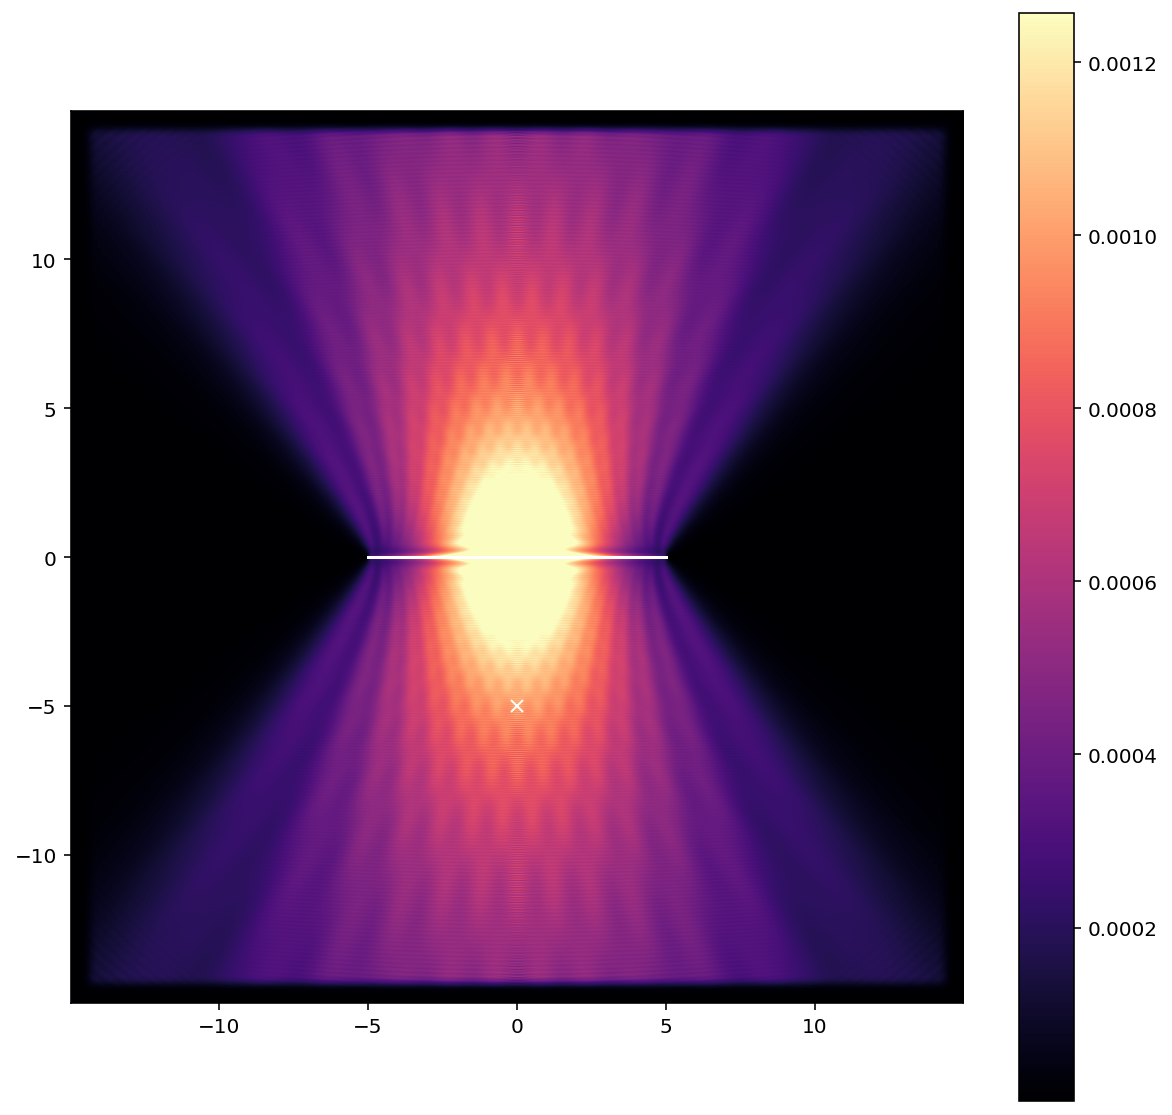

In [235]:
X, Y = np.meshgrid(metalens['x_axis'], metalens['y_axis'])
R = np.sqrt(X**2+(Y+metalens['H'])**2)
theta = np.arctan2(Y,X)
fig, ax = plt.subplots(figsize=(10,10))
this_field = np.copy(metalens['fields']['Sr'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),98)
im = ax.imshow(this_field,
          origin='lower',
          cmap='magma',
          norm=Normalize(vmin=vmin, vmax=vmax),
         extent=metalens['extent'])
ax.plot([-metalens['ws'],metalens['ws']],[0,0],'w-')
ax.plot([0],[-metalens['H']],'wx')
fig.colorbar(im)
plt.show()

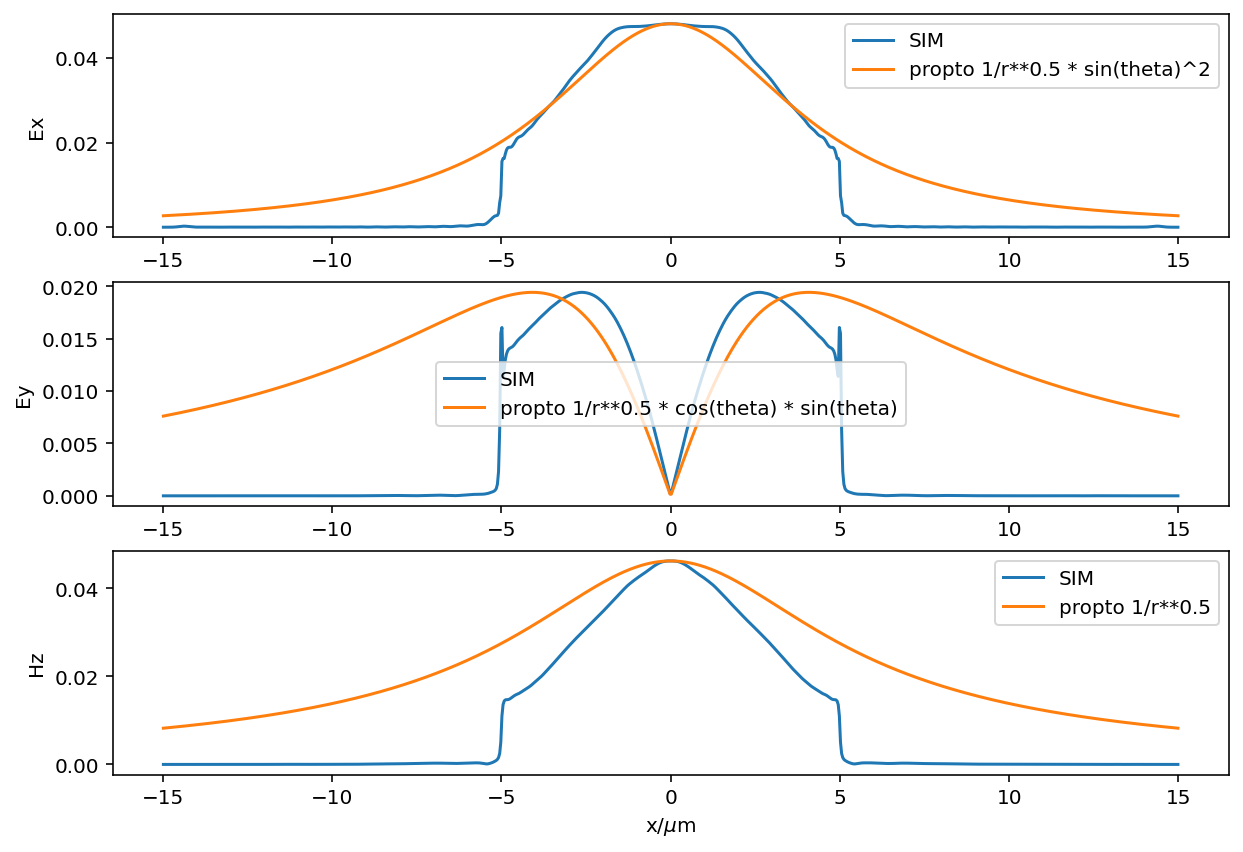

In [236]:
middle_index = np.argmin(np.abs(metalens['y_axis']))
r = np.sqrt(metalens['H']**2 + metalens['x_axis']**2)
angs = np.arctan2(metalens['H'],metalens['x_axis'])
fields = ['Ex','Ey','Hz']
powwow = 0.5

fig, axes = plt.subplots(nrows=len(fields),figsize=(10,7))
for field, axis in zip(fields, axes):
    simField = np.abs(metalens['fields'][field][middle_index])
    axis.plot(metalens['x_axis'],
              simField,
              label='SIM')
    if field == 'Ex':
        Hprime = 1 / r**powwow * np.sin(angs)**2
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='propto 1/r**%.1f * sin(theta)^2'%powwow)
    elif field == 'Ey':
        Hprime = np.abs(1 / r**powwow * np.cos(angs) * np.sin(angs))
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='propto 1/r**%.1f * cos(theta) * sin(theta)'%powwow)
    elif field == 'Hz':
        Hprime = 1 / r**powwow * np.sin(angs)
        Hprime = Hprime/max(Hprime)
        axis.plot(metalens['x_axis'],
                  Hprime*max(simField),
                  label='propto 1/r**%.1f'%powwow)
    axis.legend()
    if field == fields[-1]:
        axis.set_xlabel('x/$\mu$m')
    axis.set_ylabel(field)
plt.show()

### MEEP - eating a fiber bundle

In [ ]:
sim_fname = '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
depths = np.linspace(5,50,10)
metalenses = []
for depth in depths:
    metalens_pair = {}
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': depth, # depth of emitter
        'gap_h': 1.0,
        'gap_v': 0.,
        'b': 2.0, # distance between source and interface
        'w': 100.,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 40.,
        'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False,
        'freq_multiplier': 3, # must be an odd integer
        'log_to_pkl': [True,''],
        'NAf': 0.5
        }
    if 'NAf' in metalens.keys():
        metalens['n'] = np.sqrt(metalens['epsilon'])
        metalens['Ω'] = (metalens['wavelength']/2/metalens['unit cell size']
                         + metalens['NAf']) / metalens['n']
        metalens['R'] = metalens['H']*metalens['Ω']/np.sqrt(1-metalens['Ω']**2)
        metalens['zeta'] = np.arcsin(metalens['NAf'])
        metalens['d'] = np.tan(metalens['zeta']) * (metalens['w']-metalens['R'])
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens['incident_flux'] = get_flux_on_metalens(metalens)
    metalens = simulate_metalens(metalens)
    metalens_pair['shiny'] = metalens['sim_id']
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': depth, # depth of emitter
        'gap_h': 1.0,
        'gap_v': 0.,
        'b': 2.0, # distance between source and interface
        'w': 100.,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 40.,
        'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False,
        'freq_multiplier': 3, # must be an odd integer
        'log_to_pkl': [True,''],
        'NAf': 0.5
        }
    if 'NAf' in metalens.keys():
        metalens['n'] = np.sqrt(metalens['epsilon'])
        metalens['Ω'] = (metalens['wavelength']/2/metalens['unit cell size']
                         + metalens['NAf']) / metalens['n']
        metalens['R'] = metalens['H']*metalens['Ω']/np.sqrt(1-metalens['Ω']**2)
        metalens['zeta'] = np.arcsin(metalens['NAf'])
        metalens['d'] = np.tan(metalens['zeta']) * (metalens['w']-metalens['R'])
    metalens['R'] = metalens['w']
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens['incident_flux'] = get_flux_on_metalens(metalens)
    metalens = simulate_metalens(metalens)
    metalens_pair['control'] = metalens['sim_id']
    metalens_pair['H'] = depth
    metalenses.append(metalens_pair)

In [ ]:
pickle.dump(metalenses, 
            open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalenses-sbs.pkl','wb'))

In [ ]:
# metalenses = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalenses-sbs.pkl','rb'))['metalenses']

In [ ]:
metalenses = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalenses-sbs.pkl','rb'))

In [ ]:
merit_fun = []
for i in range(len(metalenses)):
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    metalens_shiny = compute_post_simulation_params(metalens_shiny)
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    metalens_control = compute_post_simulation_params(metalens_control)
    merit_fun.append([metalenses[i]['H'],
                      metalens_shiny['tf/if'],
                      metalens_shiny['tf/ff'],
                      metalens_control['tf/if'],
                      metalens_control['tf/ff']])
    del metalens_shiny
    del metalens_control
merit_fun = np.array(merit_fun)

In [ ]:
merit_fun = []
for i in range(len(metalenses)):
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    metalens_shiny = compute_post_simulation_params(metalens_shiny)
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    metalens_control = compute_post_simulation_params(metalens_control)
    merit_fun.append([metalenses[i]['H'],
                      metalens_shiny['tf/if'],
                      metalens_shiny['tf/ff'],
                      metalens_control['tf/if'],
                      metalens_control['tf/ff']])
    del metalens_shiny
    del metalens_control
merit_fun = np.array(merit_fun)

In [ ]:
radii = []
for i in range(len(metalenses)):
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    radii.append(metalens_shiny['R'])
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    radii.append(metalens_control['R'])
    del metalens_shiny
    del metalens_control
radii = np.array(radii)

In [ ]:
depths = np.linspace(5,50,10)

In [ ]:
print(metalenses)

In [ ]:
print_params(metalens_shiny)

In [ ]:
fig, ax = plt.subplots(nrows=3,figsize=(10,9))
ax[0].plot(depths,merit_fun[:,1],'o-',label='tf/if (shiny)',ms=4)
ax[0].plot(depths,merit_fun[:,3],'o-',label='tf/if (control)',ms=4)
ax[0].set_xlim(5,50)
ax[0].legend()
ax[1].plot(depths,merit_fun[:,2],'o-',label='tf/ff (shiny)',ms=4)
ax[1].plot(depths,merit_fun[:,4],'o-',label='tf/ff (control)',ms=4)
ax[1].set_ylim(0.2,0.4)
ax[1].set_xlim(5,50)
ax[1].legend()
ax[2].plot(depths,radii[::2],'o-',label='radii (shiny)',ms=4)
ax[2].plot(depths,radii[1::2],'o-',label='radii (control)',ms=4)
ax[2].legend()
ax[2].set_ylim(0,110)
ax[2].set_xlim(5,50)
plt.show()

In [ ]:

metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
print(metalens_shiny_fname.split('/')[-1])
metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
metalens_shiny = compute_post_simulation_params(metalens_shiny)
metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
print(metalens_control_fname.split('/')[-1])
metalens_control = pickle.load(open(metalens_control_fname,'rb'))
metalens_control = compute_post_simulation_params(metalens_control)

In [ ]:
this_metalens['H']

In [ ]:
this_metalens['detector_plane_coordinate']

In [ ]:
for i in range(len(metalenses)):
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    metalens_shiny = compute_post_simulation_params(metalens_shiny)
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    metalens_control = compute_post_simulation_params(metalens_control)
    control_field = np.abs(metalens_control['farfields']['rho_em'])
    shiny_field = np.abs(metalens_shiny['farfields']['rho_em'])
    control_field = np.abs(metalens_control['farfields']['rho_em'])
    shiny_field = np.abs(metalens_shiny['farfields']['rho_em'])
    this_field = np.concatenate((shiny_field,control_field),axis=0)
    fig, ax = plt.subplots(figsize=(10,10))
    extent_c = metalens_control['full_extent']
    extent_s = metalens_shiny['full_extent']
    extent = extent_s[:2] + [extent_s[2],extent_s[3]+(extent_c[3]-extent_s[2])]
    vmin = np.percentile(this_field.flatten(),2)
    vmax = np.percentile(this_field.flatten(),98)
    shiny_height = extent_s[3]-extent_s[2]
    ax.imshow(this_field,
              cmap=this_metalens['cmap'],
              origin='lower',
              vmin=vmin,
              vmax=vmax,
              extent=extent)
    ax.plot([-metalens_shiny['w'], metalens_shiny['w']],
             [metalens_shiny['detector_plane_coordinate']]*2,
             'wx',
             ms=5)
    ax.plot([-metalens_shiny['R'], metalens_shiny['R']],
             [this_metalens['interface_coordinate']]*2,
             'wx',
             marker = "|",
             ms=5)
    ax.plot([-metalens_control['w'], metalens_control['w']],
             [metalens_control['detector_plane_coordinate']+shiny_height]*2,
             'wx',
             ms=5)
    ax.plot([-metalens_control['R'], metalens_control['R']],
             [metalens_control['interface_coordinate']+shiny_height]*2,
             'wx',
             marker = "|",
             ms=5)
    ax.set_xlabel('x/$\mu$m')
    ax.set_ylabel('y/$\mu$m')
    ax.set_xlim(-105,105)
    ax.set_yticklabels([])
    plt.title('H={H}$\mu$m'.format(H=metalens_shiny['H']))
    #fig.subplots_adjust(hspace=0.1)
    plt.tight_layout()
    plt.savefig("/Users/juan/Temp/metalenses-sbs-%d.png" % metalens_control['H'],
               dpi=200)
    plt.close()

In [ ]:
os.system('pushover "done"')

In [ ]:
control_field = np.abs(metalens_control['farfields']['rho_em'])
shiny_field = np.abs(metalens_shiny['farfields']['rho_em'])
fig, axes = plt.subplots(nrows=2)
for ax_index, axis in enumerate(axes):
    this_field = [shiny_field, control_field][ax_index]
    this_metalens = [metalens_shiny, metalens_control][ax_index]
    vmin = np.percentile(this_field.flatten(),2)
    vmax = np.percentile(this_field.flatten(),98)
    axis.imshow(this_field,
              cmap=this_metalens['cmap'],
              origin='lower',
              vmin=vmin,
              vmax=vmax,
              extent=this_metalens['full_extent'])
    axis.plot([-this_metalens['w'], this_metalens['w']],
             [this_metalens['detector_plane_coordinate']]*2,
             'wx',
             ms=5)
    axis.plot([-this_metalens['R'], this_metalens['R']],
             [this_metalens['interface_coordinate']]*2,
             'wx',
             marker = "|",
             ms=5)
    if ax_index == 1:
        axis.set_xlabel('x/$\mu$m')
    axis.set_ylabel('y/$\mu$m')
    axis.set_xlim(-105,105)
    #axis.set_ylim(-1.5,55)
    if ax_index == 0:
        axis.set_xticklabels([])
#fig.subplots_adjust(hspace=0.1)
# plt.savefig("/Users/juan/Temp/metalenses-sbs-%d.png" % this_metalens['H'],
#            dpi=200)
plt.tight_layout()
plt.show()


In [ ]:
for i in range(len(metalenses)):
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    metalens_shiny = compute_post_simulation_params(metalens_shiny)
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    metalens_control = compute_post_simulation_params(metalens_control)
    control_field = np.abs(metalens_control['farfields']['rho_em'])
    shiny_field = np.abs(metalens_shiny['farfields']['rho_em'])
    fig, axes = plt.subplots(nrows=2, figsize=(10,6))
    for ax_index, axis in enumerate(axes):
        this_field = [shiny_field, control_field][ax_index]
        this_metalens = [metalens_shiny, metalens_control][ax_index]
        vmin = np.percentile(this_field.flatten(),2)
        vmax = np.percentile(this_field.flatten(),98)
        axis.imshow(this_field,
                  cmap=this_metalens['cmap'],
                  origin='lower',
                  vmin=vmin,
                  vmax=vmax,
                  extent=this_metalens['full_extent'])
        axis.plot([-this_metalens['w'], this_metalens['w']],
                 [this_metalens['detector_plane_coordinate']]*2,
                 'wx',
                 ms=5)
        axis.plot([-this_metalens['R'], this_metalens['R']],
                 [this_metalens['interface_coordinate']]*2,
                 'wx',
                 marker = "|",
                 ms=5)
        if ax_index == 1:
            axis.set_xlabel('x/$\mu$m')
        axis.set_ylabel('y/$\mu$m')
        axis.set_xlim(-105,105)
        axis.set_ylim(-1.5,55)
        if ax_index == 0:
            axis.set_xticklabels([])
    #fig.subplots_adjust(hspace=0.1)
    plt.savefig("/Users/juan/Temp/metalenses-sbs-%d.png" % this_metalens['H'],
               dpi=200)
    plt.close()
    break

In [ ]:
os.system('say "finished"')

### MEEP - gradient boost

In [ ]:
sim_fname = '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
depths = np.linspace(5,50,10)
metalenses = []
for depth in depths:
    metalens_pair = {}
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': depth, # depth of emitter
        'gap_h': 1.0,
        'gap_v': 0.,
        'b': 2.0, # distance between source and interface
        'w': 100.,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 40.,
        'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False,
        'freq_multiplier': 3, # must be an odd integer
        'log_to_pkl': [True,''],
        'NAf': 0.5,
        'gradient_boost': 1.1
        }
    if 'NAf' in metalens.keys():
        metalens['n'] = np.sqrt(metalens['epsilon'])
        if 'gradient_boost' not in metalens.keys():
            metalens['Ω'] = (metalens['wavelength']/2/metalens['unit cell size']
                             + metalens['NAf']) / metalens['n']
        else:
            metalens['Ω'] = (metalens['gradient_boost']*metalens['wavelength']/2/metalens['unit cell size']
                             + metalens['NAf']) / metalens['n']
        metalens['R'] = metalens['H']*metalens['Ω']/np.sqrt(1-metalens['Ω']**2)
        metalens['zeta'] = np.arcsin(metalens['NAf'])
        metalens['d'] = np.tan(metalens['zeta']) * (metalens['w']-metalens['R'])
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens['incident_flux'] = get_flux_on_metalens(metalens)
    metalens = simulate_metalens(metalens)
    metalens_pair['shiny'] = metalens['sim_id']
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': depth, # depth of emitter
        'gap_h': 1.0,
        'gap_v': 0.,
        'b': 2.0, # distance between source and interface
        'w': 100.,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 40.,
        'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False,
        'freq_multiplier': 3, # must be an odd integer
        'log_to_pkl': [True,''],
        'NAf': 0.5,
        'gradient_boost': 1.1
        }
    if 'NAf' in metalens.keys():
        metalens['n'] = np.sqrt(metalens['epsilon'])
        if 'gradient_boost' not in metalens.keys():
            metalens['Ω'] = (metalens['wavelength']/2/metalens['unit cell size']
                             + metalens['NAf']) / metalens['n']
        else:
            metalens['Ω'] = (metalens['gradient_boost']*metalens['wavelength']/2/metalens['unit cell size']
                             + metalens['NAf']) / metalens['n']
        metalens['R'] = metalens['H']*metalens['Ω']/np.sqrt(1-metalens['Ω']**2)
        metalens['zeta'] = np.arcsin(metalens['NAf'])
        metalens['d'] = np.tan(metalens['zeta']) * (metalens['w']-metalens['R'])
    metalens['R'] = metalens['w']
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens['incident_flux'] = get_flux_on_metalens(metalens)
    metalens = simulate_metalens(metalens)
    metalens_pair['control'] = metalens['sim_id']
    metalens_pair['H'] = depth
    metalenses.append(metalens_pair)

In [ ]:
pickle.dump(metalenses, 
            open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalenses-sbs-boosted-1p1.pkl','wb'))

In [ ]:
# metalenses = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalenses-sbs.pkl','rb'))['metalenses']

In [ ]:
# metalenses = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalenses-sbs.pkl','rb'))

In [ ]:
print_params(metalens_shiny)

In [ ]:
merit_fun = []
for i in range(len(metalenses)):
#     if i == 4:
#         break
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    metalens_shiny = compute_post_simulation_params(metalens_shiny)
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    metalens_control = compute_post_simulation_params(metalens_control)
    merit_fun.append([metalenses[i]['H'],
                      metalens_shiny['tf/if'],
                      metalens_shiny['tf/ff'],
                      metalens_control['tf/if'],
                      metalens_control['tf/ff']])
    del metalens_shiny
    del metalens_control
merit_fun = np.array(merit_fun)

In [ ]:
dees = []
for i in range(len(metalenses)):
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    dees.append(metalens_shiny['d'])
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    dees.append(metalens_control['d'])
    del metalens_shiny
    del metalens_control
dees = np.array(dees)

In [ ]:
radii = []
for i in range(len(metalenses)):
#     if i == 2:
#         break
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    radii.append(metalens_shiny['R'])
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    radii.append(metalens_control['R'])
    del metalens_shiny
    del metalens_control
radii = np.array(radii)

In [ ]:
fig, ax = plt.subplots(nrows=3,figsize=(10,9))
ax[0].plot(depths,merit_fun[:,1],'o-',label='tf/if (shiny)',ms=4)
ax[0].plot(depths,merit_fun[:,3],'o-',label='tf/if (control)',ms=4)
ax[0].set_xlim(5,50)
ax[0].legend()
ax[1].plot(depths,merit_fun[:,2],'o-',label='tf/ff (shiny)',ms=4)
ax[1].plot(depths,merit_fun[:,4],'o-',label='tf/ff (control)',ms=4)
ax[1].set_ylim(0.2,0.4)
ax[1].set_xlim(5,50)
ax[1].legend()
ax[2].plot(depths,radii[::2],'o-',label='radii (shiny)',ms=4)
ax[2].plot(depths,radii[1::2],'o-',label='radii (control)',ms=4)
ax[2].legend()
ax[2].set_ylim(0,110)
ax[2].set_xlim(5,50)
plt.show()

In [ ]:
for i in range(len(metalenses)):
#     if i == 2:
#         break
    metalens_shiny_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['shiny']
    print(metalens_shiny_fname.split('/')[-1])
    metalens_shiny = pickle.load(open(metalens_shiny_fname,'rb'))
    metalens_shiny = compute_post_simulation_params(metalens_shiny)
    metalens_control_fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % metalenses[i]['control']
    print(metalens_control_fname.split('/')[-1])
    metalens_control = pickle.load(open(metalens_control_fname,'rb'))
    metalens_control = compute_post_simulation_params(metalens_control)
    control_field = np.abs(metalens_control['farfields']['rho_em'])
    shiny_field = np.abs(metalens_shiny['farfields']['rho_em'])
    control_field = np.abs(metalens_control['farfields']['rho_em'])
    shiny_field = np.abs(metalens_shiny['farfields']['rho_em'])
    this_field = np.concatenate((shiny_field,control_field),axis=0)
    fig, ax = plt.subplots(figsize=(10,10))
    extent_c = metalens_control['full_extent']
    extent_s = metalens_shiny['full_extent']
    extent = extent_s[:2] + [extent_s[2],extent_s[3]+(extent_c[3]-extent_s[2])]
    vmin = np.percentile(this_field.flatten(),2)
    vmax = np.percentile(this_field.flatten(),98)
    shiny_height = extent_s[3]-extent_s[2]
    ax.imshow(this_field,
              cmap=metalens_shiny['cmap'],
              origin='lower',
              vmin=vmin,
              vmax=vmax,
              extent=extent)
    ax.plot([-metalens_shiny['w'], metalens_shiny['w']],
             [metalens_shiny['detector_plane_coordinate']]*2,
             'wx',
             ms=5)
    ax.plot([-metalens_shiny['R'], metalens_shiny['R']],
             [metalens_shiny['interface_coordinate']]*2,
             'wx',
             marker = "|",
             ms=5)
    ax.plot([-metalens_control['w'], metalens_control['w']],
             [metalens_control['detector_plane_coordinate']+shiny_height]*2,
             'wx',
             ms=5)
    ax.plot([-metalens_control['R'], metalens_control['R']],
             [metalens_control['interface_coordinate']+shiny_height]*2,
             'wx',
             marker = "|",
             ms=5)
    ax.set_xlabel('x/$\mu$m')
    ax.set_ylabel('y/$\mu$m')
    ax.set_xlim(-105,105)
    ax.set_yticklabels([])
    plt.title('H={H}$\mu$m'.format(H=metalens_shiny['H']))
    #fig.subplots_adjust(hspace=0.1)
    plt.tight_layout()
    plt.savefig("/Users/juan/Temp/metalenses-sbs-boosted-1p1-%d.png" % metalens_control['H'],
               dpi=200)
    plt.close()

In [ ]:
os.system('pushover "done"')

### MEEP - eating fiber

In [ ]:
sim_fname = '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 0.0,
    'H': 50, # depth of emitter
    'gap_h': 1.0,
    'gap_v': 0.,
    'b': 2.0, # distance between source and interface
    'w': 100.,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 40.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True,
    'quiet': True,
    'freq_multiplier': 3, # must be an odd integer
    'log_to_pkl': [False,''],
    'NAf': 0.5
    }
if 'NAf' in metalens.keys():
    metalens['n'] = np.sqrt(metalens['epsilon'])
    metalens['Ω'] = (metalens['wavelength']/2/metalens['unit cell size']
                     + metalens['NAf']) / metalens['n']
    metalens['R'] = metalens['H']*metalens['Ω']/np.sqrt(1-metalens['Ω']**2)
    metalens['zeta'] = np.arcsin(metalens['NAf'])
    metalens['d'] = np.tan(metalens['zeta']) * (metalens['w']-metalens['R'])
metalens['w'] = metalens['R']

In [ ]:
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)
metalens['incident_flux'] = get_flux_on_metalens(metalens)
metalens = simulate_metalens(metalens)
metalens = compute_post_simulation_params(metalens)

In [ ]:
metalens['tf/ff']

In [ ]:
this_field = np.abs(metalens['farfields']['rho_em'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_field,
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wx',
         ms=5)
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.xlim(-1.1*metalens['w'],1.1*metalens['w'])
plt.show()

In [ ]:
metalens['R']

In [ ]:
metalens['detector_plane_coordinate']

In [ ]:
90-np.arcsin(metalens['NAf'])*180/np.pi

### MEEP - in the deep

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
depth = 800
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 0.0,
    'H': depth, # depth of emitter
    'gap_h': 1.0,
    'gap_v': 0.,
    'b': 2.0, # distance between source and interface
    'w': 25.,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 40.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True,
    'quiet': True,
    'freq_multiplier': 3, # must be an odd integer
    'log_to_pkl': [False,'']
    }
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)
metalens['incident_flux'] = get_flux_on_metalens(metalens)
metalens = simulate_metalens(metalens)
metalens = compute_post_simulation_params(metalens)
#gotchaHR.append([depth, metalens['tf/if'], metalens['tf/ff']])
metalens['tf/if']

In [ ]:
this_field = np.abs(metalens['farfields']['rho_em'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_field,
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wx',
         ms=1)
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.show()

In [ ]:
depths = np.linspace(5,100,20)

In [ ]:
gotchaHR = []
for depth in depths:
    print('H=%.1f' % depth)
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': depth, # depth of emitter
        'gap_h': 1.0,
        'gap_v': 0.,
        'b': 2.0, # distance between source and interface
        'w': 25.,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 50.,
        'sim_id': simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': True,
        'freq_multiplier': 3, # must be an odd integer
        'log_to_pkl': [False,'']
        }
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens['incident_flux'] = get_flux_on_metalens(metalens)
    metalens = simulate_metalens(metalens)
    metalens = compute_post_simulation_params(metalens)
    gotchaHR.append([depth, metalens['tf/if'], metalens['tf/ff']])
gotchaHR = np.array(gotchaHR)

In [ ]:
!pushover "done"

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,10))
title_string = '''resolution={resolution}, d={d}$\,\mu$m
    $\lambda$={wavelength}$\,\mu$m, R={R}$\mu$m, h={post_height}$\mu$m
    cell_width = {cell_width}$\mu$m, w={w}$\mu$m
    normal transmission = {normal_incidence_transmission:.2f}'''
#plt.plot(gotcha[:,0],100*gotchaHR[:,1],label='transmitted power / incident power')
plt.plot(gotchaHR[:,0],100*gotchaHR[:,1],label='transmitted power / incident power')
plt.xlabel('H/$\mu$m')
plt.ylabel('%')
plt.ylim(0,80.)
plt.legend()
plt.grid(True)
plt.title(title_string.format(**metalens))
plt.show()

In [ ]:
gotchaHR

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,10))
title_string = '''resolution={resolution}, d={d}$\,\mu$m
    $\lambda$={wavelength}$\,\mu$m, R={R}$\mu$m, h={post_height}$\mu$m
    cell_width = {cell_width}$\mu$m, w={w}$\mu$m
    normal transmission = {normal_incidence_transmission:.2f}'''
plt.plot(gotchaHR[:,0],100*gotchaHR[:,1],label='transmitted power / incident power')
plt.plot(gotchaHR[:,0],100*gotchaHR[:,2],label='transmitted power / total radiated power')
plt.xlabel('H/$\mu$m')
plt.ylabel('%')
#plt.ylim(0,30.)
plt.legend()
plt.grid(True)
plt.title(title_string.format(**metalens))
plt.show()

In [ ]:
print("target_flux/incident_flux = %.1f%%"  % (100*metalens['tf/if']))
print("target_flux/full_flux = %.1f%%"  % (100*metalens['tf/ff']))

In [ ]:
this_field = np.abs(metalens['farfields']['rho_em'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_field,
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wx',
         ms=1)
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.show()

In [ ]:
ws = np.array([5.,10.,15.,20.,25.,30.])
Hs = np.array([5.,10.,15.,20.,25.,30.])

In [ ]:
metalenses_params = []
for w, H in itertools.product(ws,Hs):
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': H, # depth of emitter
        'gap_h': 1.0,
        'gap_v': 0.,
        'b': 2.0, # distance between source and interface
        'w': w,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 50.,
        'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': True,
        'freq_multiplier': 3, # must be an odd integer
        'log_to_pkl': [True,'']
        }
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalenses_params.append(metalens)

In [ ]:
def quick_metal(metalens,cue):
    metalens['incident_flux'] = get_flux_on_metalens(metalens)
    metalens = simulate_metalens(metalens)
    print(metalens['sim_id'])
    cue.put(metalens)
# metalenses = multip.Pool(processes=4).map(quick_metal, metalenses_params[:4], chunksize=1);
cue = multip.Queue()
processes = [multip.Process(target=quick_metal,
            args=(metalens,cue)) for metalens in metalenses_params[:4]]
for p in processes:
    p.start()
for p in processes:
    p.join()
metalenses = [cue.get() for p in processes];

In [ ]:
25/36*4

In [ ]:
!pushover "done"

In [ ]:
ws = np.array([5.,10.,15.,20.,25.,30.])
Hs = np.array([5.,10.,15.,20.,25.,30.])
atlante_parallel = {}
for w in ws:
    for H in Hs:
        print('H=%.1f, w=%.1f' % (H, w))
        metalens = {
            'post_height':simulation_parameters['post_height'],
            'R': 25,
            'd': 50.,
            's': 0.0,
            'H': H, # depth of emitter
            'gap_h': 1.0,
            'gap_v': 0.,
            'b': 2.0, # distance between source and interface
            'w': w,
            'unit cell size': simulation_parameters['cell_width'],
            'epsilon': simulation_parameters['epsilon'],
            'phases': phases,
            'widths': post_widths,
            'wavelength': simulation_parameters['wavelength'],
            'min_width': 0.05,
            'pml_width': 1.0,
            'resolution': 50.,
            'sim_id': str(int(time.time())), #simulation_parameters['sim_id'],
            'simulation_parameters' : simulation_parameters,
            'complex_fields' : True,
            'save_output': False,
            'x_mirror_symmetry': True,
            'quiet': True,
            'freq_multiplier': 3, # must be an odd integer
            'log_to_pkl': [True,'']
            }
        metalens = aux_params(metalens)
        metalens = make_metalens_geometry(metalens)
        metalens['incident_flux'] = get_flux_on_metalens(metalens)
        metalens = para_metalens(metalens,4)
        atlante_parallel[(w,H)] = metalens['sim_id']

In [ ]:
pickle.dump(atlante, open('/Users/juan/Google Drive/Zia Lab/Log/Data/atlante-1.pkl','wb'))

In [ ]:
atlante = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/atlante-1.pkl','rb'))

In [ ]:
fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % atlante[(10,10)]
metalens = pickle.load(open(fname,'rb'))

In [ ]:
print_params(metalens)

In [ ]:
merit_tf_if = []
merit_tf_ff = []
ws = np.array([5.,10.,15.,20.,25.,30.])
Hs = np.array([5.,10.,15.,20.,25.,30.])
for w in ws:
    constant_w_1 = []
    constant_w_2 = []
    for H in Hs:
        #load it
        fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % atlante_parallel[(w,H)]
        metalens = pickle.load(open(fname,'rb'))
        #compute farfields
        metalens = compute_post_simulation_params(metalens)
        constant_w_1.append(metalens['tf/if'])
        constant_w_2.append(metalens['tf/ff'])
    merit_tf_if.append(constant_w_1)
    merit_tf_ff.append(constant_w_2)
merit_tf_if = np.array(merit_tf_if)
merit_tf_ff = np.array(merit_tf_ff)

In [ ]:
!say "done"

In [ ]:
constant_w_2

In [ ]:
for w_index, w in enumerate(ws):
    for h_index, H in enumerate(Hs):
        print("{%.1f,%.1f,%.3f}," % (w, H, merit[w_index][h_index]))

In [ ]:
merit_tf_ff

In [ ]:

fig, axes = plt.subplots(ncols=2,figsize=(7*2,7))
for merit, ax, this_title in zip([merit_tf_ff, merit_tf_if],
                     axes,
                    ['flux on target / full flux',
                    'flux on target / incident flux']):
    im = ax.imshow(merit,
              origin='lower',
              cmap = 'magma',
              extent=[5-2.5,35-2.5,5-2.5,35-2.5])
    # cax = ax.add_axes([0.95, 0.075, 0.05, 0.85])
    for H_index, H in enumerate(Hs):
        for w_index, w in enumerate(ws): 
            ax.text(H, w, "%.2f" % merit[w_index][H_index],
                    va='center',ha='center',color='white',fontsize=10)
    ax.set_title(this_title)
    fig.colorbar(im, ax=ax)
    ax.set_ylabel('w/$\mu$m')
    ax.set_xlabel('H/$\mu$m')
plt.show()

In [ ]:
!pushover "done"

In [ ]:
for w in ws:
    for H in Hs:
        #load it
        fname = '/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-%s.pkl' % atlante_parallel[(w,H)]
        metalens = pickle.load(open(fname,'rb'))
        #compute farfields
        metalens = compute_post_simulation_params(metalens)
        plotfname = '/Users/juan/Temp/metalens-%d-%d.png' % (w,H)
        #make and save plot
        this_field = (metalens['farfields']['rho_em'])
        vmin = np.percentile(this_field.flatten(),5)
        vmax = np.percentile(this_field.flatten(),95)
        plt.figure(figsize=(10,5))
        plt.imshow(this_field,
                  cmap=metalens['cmap'],
                  origin='lower',
                  vmin=vmin,
                  vmax=vmax,
                  extent=metalens['full_extent'])
        plt.plot([-metalens['w'], -metalens['w'],-metalens['w'],-metalens['w']-2],
                 [metalens['detector_plane_coordinate']+1,
                 metalens['detector_plane_coordinate']-1,
                 metalens['detector_plane_coordinate'],
                 metalens['detector_plane_coordinate']],
                 'w-')
        plt.plot([metalens['w'], metalens['w'],metalens['w'],metalens['w']+2],
                 [metalens['detector_plane_coordinate']+1,
                 metalens['detector_plane_coordinate']-1,
                 metalens['detector_plane_coordinate'],
                 metalens['detector_plane_coordinate']],
                 'w-')
        plt.plot([60-metalens['R']*0.25,60+metalens['R']*0.25],[20-10]*2,'w-')
        plt.plot([60],[20-metalens['H']*0.25-10],'wx')
        plt.plot([60-metalens['w']*0.25,
                 60+metalens['w']*0.25],[20+metalens['d']*0.25-10]*2,'w-')
        plt.xlabel('x/$\mu$m')
        plt.ylabel('y/$\mu$m')
        plt.text(60,50,'H=%d $\mu$m w=%d $\mu$m' % (w,H),va='center',ha='center',
                color='white')
        plt.xlim(-40,80)
        plt.ylim(metalens['full_extent'][2],53)
        plt.tight_layout()
        print("Saving figure...")
        plt.savefig(plotfname, dpi=300)
        plt.close()

In [ ]:
!say "done"

In [ ]:
this_field.shape

In [ ]:
pickle.dump(atlante_parallel, open('/Users/juan/Google Drive/Zia Lab/Log/Data/atlante-1.pkl','wb'))

In [ ]:
!pushover "done"

### MEEP - flux through target

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 0.0,
    'H': 20., # depth of emitter
    'gap_h': 1.0,
    'gap_v': 0.,
    'b': 2.0, # distance between source and interface
    'w': 10.,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 30.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True,
    'quiet': True,
    'freq_multiplier': 3 # must be an odd integer
    }
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)
metalens['incident_flux'] = get_flux_on_metalens(metalens)
metalens = simulate_metalens(metalens)

In [ ]:
metalens = compute_post_simulation_params(metalens)

In [ ]:
print("target_flux/incident_flux = %.1f%%"  % (100*metalens['tf/if']))
print("target_flux/full_flux = %.1f%%"  % (100*metalens['tf/ff']))

### MEEP - Flux Capacitor

In [ ]:
# given the size of the custom source
# the wavelength
# and the index of refraction
# determine the amount of radiant flux it would emit in 
# a homogeneous medium
# understand how this scales with resolution

* there is no dependence on wavelength
* it is inversely proportional to the refractive index


In [ ]:
def source_flux(wave=1.0,
               resolution=30,
               epsilon=1.0):
    metalens = {'sim_cell_width':40,
               'sim_cell_height':20.,
               'pml_width':1,
               'source_width': 0,
               'wavelength':wave,
               'source_coordinate':0,
               'ws':5,
               'x_mirror_symmetry': True,
               'complex_fields': True,
               'resolution':40.,
               'quiet': True,
               'epsilon': epsilon,
               'H': 10.,
               's': 0.}
    metalens['gate_radius'] = metalens['ws']
    metalens['n'] = np.sqrt(metalens['epsilon'])
    metalens['k'] = metalens['n']*2.*np.pi/metalens['wavelength']
    metalens['simulation_time'] = (metalens['source_width']+
                                   3*metalens['n']
                                   *metalens['wavelength']
                                  /metalens['wavelength'])

    # Setup the MEEP objects
    cell = mp.Vector3(metalens['sim_cell_width'],
                      metalens['sim_cell_height'])
    # All around the simulation cell
    pml_layers = [ mp.PML(metalens['pml_width']) ]
    amp_func = far_ez_source_amp_func(metalens)
    # Set up the sources
    sources = [mp.Source(src=mp.ContinuousSource(
                         wavelength=metalens['wavelength'],
                         width=metalens['source_width']
                        ),
              component=mp.Ez,
              center=mp.Vector3(0, metalens['source_coordinate']),
              size=mp.Vector3(2 * metalens['ws'], 0),
              amp_func=amp_func)]
    # Set up the symmetries
    metalens['geometry'] = [mp.Block(size = mp.Vector3(metalens['sim_cell_width'],
                                                metalens['sim_cell_height']),
                            center = mp.Vector3(0,0),
                            material = mp.Medium(epsilon = metalens['epsilon']))]
    syms = []
    if metalens['x_mirror_symmetry']:
        syms.append(mp.Mirror(mp.X))
    sim = mp.Simulation(cell_size=cell,
                boundary_layers=pml_layers,
                geometry=metalens['geometry'],
                force_complex_fields=metalens['complex_fields'],
                symmetries=syms,
                sources=sources,
                resolution=metalens['resolution'])
    mp.quiet(metalens['quiet'])
    sim.init_sim()
    sim.run(until=metalens['simulation_time']) 
    metalens['fields'] = {'Ez': sim.get_array(component=mp.Ez).transpose(),
                          'Hx': sim.get_array(component=mp.Hx).transpose(),
                          'Hy': sim.get_array(component=mp.Hy).transpose()}
    metalens['optical_axis'] = np.linspace(-metalens['sim_cell_height']/2,
                                          metalens['sim_cell_height']/2,
                                          metalens['fields']['Ez'].shape[0])
    metalens['interface_index'] =  np.argmin(
                                   np.abs(metalens['optical_axis']))
    metalens['gate_index'] = metalens['interface_index'] + 1
    metalens['extent'] = [-metalens['sim_cell_height']/2,
                         metalens['sim_cell_height']/2,
                         -metalens['sim_cell_width']/2,
                         metalens['sim_cell_width']/2]
    metalens['transverse_axis'] = (
        np.linspace(-metalens['sim_cell_width']/2,
        metalens['sim_cell_width']/2,
        metalens['fields']['Ez'].shape[1]))
    metalens['source_amps'] = [amp_func(mp.Vector3(x,0)) 
                               for x in metalens['transverse_axis']]
    metalens['fields']['Sy'] = np.real(np.conjugate(metalens['fields']['Ez'])
                              * metalens['fields']['Hx'])
    metalens['Sy_on_gate'] = metalens['fields']['Sy'][metalens['gate_index']]
    metalens['total_flux'] = np.sum(metalens['Sy_on_gate']
            [metalens['transverse_axis']<=metalens['gate_radius']])
    return (np.abs(metalens['source_amps']), metalens['total_flux'])

In [ ]:
wavelengths = np.linspace(0.5,2,10)
fluxes = np.array([source_flux(wave=wave,
                              resolution=30,
                              epsilon=1.0) for wave in wavelengths])
plt.figure(figsize=(10,2))
plt.plot(wavelengths,
        fluxes[:,1],
        'o-',ms=2)
# plt.ylim(0,0.1)
plt.show()

In [ ]:
metalens['geometry']

In [ ]:
epsilons = np.linspace(1,5.,11)
fluxes = np.array([source_flux(wave=1.0,resolution=30,epsilon=epsilon) for epsilon in epsilons])
plt.figure(figsize=(10,2))
plt.plot(epsilons,
        fluxes[:,1],
        'o-',ms=2)
plt.plot(epsilons,
        fluxes[:,1][0]/np.sqrt(epsilons))
plt.show()

In [ ]:
# list(map(lambda x: np.sum(x**2),fluxes[:,0]))

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(epsilons,
        fluxes[:,0],
        'o-',ms=2)
plt.plot(epsilons,
        fluxes[:,1][0]/np.sqrt(epsilons))
plt.show()

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(metalens['transverse_axis'],
        np.abs(metalens['source_amps']))
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.real(metalens['fields']['Sy']),
          extent=metalens['extent'],
          origin='lower',
          cmap='magma')
plt.show()

### MEEP - change the horizontal gap with improved farfield

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalenses = []
gap_hs = [0,2,4]
for gap_h in gap_hs:
    os.system('say "[[volm 0.3]] %.1f"' % gap_h)
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': 50., # depth of emitter
        'gap_h': gap_h,
        'gap_v': 0.,
        'b': 0.0,
        'w': 0.1,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 40.,
        'sim_id': simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False,
        'freq_multiplier': 3}
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens = simulate_metalens(metalens)
    metalens = compute_post_simulation_params(metalens)
    metalenses.append(metalens)
del metalens

In [ ]:
!say "done"

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
for metalens in metalenses:
    strip = (metalens['rho_em'][metalens['nearfield_index']])
    x_axis = metalens['transverse_axis_extended']
    plt.plot(x_axis, strip,
             '-',lw=0.75,
            label="{gap} $\mu$m".format(gap = metalens['gap_h']))
plt.ylabel(r'$\rho_{EM}$')
plt.xlim(0,10)
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(nrows=3, figsize=(10,7))
for index2, ax in enumerate(axes):
    for index, metalens in enumerate(metalenses):
        strip = (metalens['rho_em'][:,metalens['optical_axis_index']]
                 + 4*0.01e-5*index)
        x_axis = np.linspace(-metalens['sim_cell_height']/2,
                             metalens['detector_plane_coordinate']
                             + metalens['top_plus'],
                             len(strip))
        ax.plot([metalens['nearfield_coordinate']]*2,[0,3e-5],'--',
                lw=0.5)
        ax.plot(x_axis,strip,
                 '-',lw=0.75,
                label="{gap} $\mu$m".format(gap = metalens['gap_h']))
        ax.set_xlim(60./3*index2, 60./3*(index2 + 1))
        ax.set_ylim(0,[0.5,0.5,1.5][index2]*1e-5)
    ax.legend(bbox_to_anchor=(1.01, 1.05),loc="upper left")
    ax.set_ylabel(r'$\rho_{EM}$')
fig.subplots_adjust(hspace=0.4)
plt.show()

### MEEP - zero padding for FFT

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 0.0,
    'H': 50., # depth of emitter
    'gap_h': 1.0,
    'gap_v': 0.,
    'b': 2.0, # distance between source and interface
    'w': 15.,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 40.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True,
    'quiet': True,
    'freq_multiplier': 3 # must be an odd integer
    }
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)
metalens = simulate_metalens(metalens)

In [ ]:
metalens = compute_post_simulation_params(metalens)
#print("FFT/IF = %.1f%%"  % (100*metalens['FTT/IF']))

In [ ]:
this_field = np.abs(metalens['farfields']['rho_em'])
vmin = np.percentile(this_field.flatten(),5)
vmax = np.percentile(this_field.flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_field,
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wx',
         ms=1)
# plt.ylim(-2,0)
# plt.xlim(0,30)
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.show()

In [ ]:
# stitched_rho_em = np.concatenate((metalens['rho_em'],
#                                  metalens['rho_em'],
#                                  metalens['rho_em']),axis=1)

In [ ]:
vmin = np.percentile(metalens['farfields']['rho_em'].flatten(),5)
vmax = np.percentile(metalens['farfields']['rho_em'].flatten(),95)
chunks = 3
chunk_width = metalens['sim_cell_width']/chunks/2
aspectratio = (metalens['wavelength']*3)/(chunk_width)
fig, axes = plt.subplots(nrows=chunks,
             figsize=(13,13*aspectratio*chunks))
for chunk, ax in enumerate(axes):
    ax.imshow(metalens['farfields']['rho_em'],
              cmap=metalens['cmap'],
              origin='lower',
              vmin=vmin,
              vmax=vmax,
              extent=metalens['full_extent'])
    ax.plot([-metalens['w'], metalens['w']],
             [metalens['detector_plane_coordinate']]*2,
             'wx',
             ms=1)
    ax.plot(metalens['contour'][:,0],
            metalens['contour'][:,1],'w--',alpha=0.5)
    ax.set_xlim(chunk_width*chunk,chunk_width*(chunk+1))
    ax.set_ylim(metalens['interface_coordinate']-metalens['wavelength']*1,
             metalens['interface_coordinate']+metalens['wavelength']*2)
fig.subplots_adjust(hspace=0.4)
plt.show()

### MEEP - change the horizontal gap

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalenses = []
gap_hs = [20,40,60,80,100]
for gap_h in gap_hs:
    os.system('say "[[volm 0.3]] %.1f"' % gap_h)
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': 50., # depth of emitter
        'gap_h': gap_h,
        'gap_v': 0.,
        'b': 0.0,
        'w': 0.1,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 40.,
        'sim_id': simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False}
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens = simulate_metalens(metalens)
    metalens = compute_post_simulation_params(metalens)
    metalenses.append(metalens)
del metalens

In [ ]:
!say "done"

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
for metalens in metalenses:
    strip = (metalens['rho_em'][metalens['nearfield_index']])
    x_axis = metalens['transverse_axis']
    plt.plot(x_axis, strip,
             '-',lw=0.75,
            label="{gap} $\mu$m".format(gap = metalens['gap_h']))
plt.ylabel(r'$\rho_{EM}$')
plt.xlim(0,10)
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(nrows=3, figsize=(10,7))
for index2, ax in enumerate(axes):
    for index, metalens in enumerate(metalenses):
        strip = (metalens['rho_em'][:,metalens['optical_axis_index']]
                 + 4*0.01e-5*index)
        x_axis = np.linspace(-metalens['sim_cell_height']/2,
                             metalens['detector_plane_coordinate']
                             + metalens['top_plus'],
                             len(strip))
        ax.plot([metalens['nearfield_coordinate']]*2,[0,3e-5],'--',
                lw=0.5)
        ax.plot(x_axis,strip,
                 '-',lw=0.75,
                label="{gap} $\mu$m".format(gap = metalens['gap_h']))
        ax.set_xlim(60./3*index2, 60./3*(index2 + 1))
        ax.set_ylim(0,[0.5,0.5,1.5][index2]*1e-5)
    ax.legend(bbox_to_anchor=(1.01, 1.05),loc="upper left")
    ax.set_ylabel(r'$\rho_{EM}$')
fig.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
kay=np.array([1,2,3])

In [ ]:
round(0.9999)

In [ ]:
padman = np.zeros(len(kay))

In [ ]:
np.concatenate((padman, kay, padman))

In [ ]:
metalens = metalenses[-1]
vmin = np.percentile(metalens['rho_em'].flatten(),5)
vmax = np.percentile(metalens['rho_em'].flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(metalens['rho_em'],
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wo',
         ms=1)
plt.show()

In [ ]:
!pushover "done"

### MEEP - change the vertical gap

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalenses = []
gap_vs = [0,2,4,6,8]
for gap_v in gap_vs:
    os.system('say %f' % gap_v)
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': 50., # depth of emitter
        'gap_h': 2.,
        'gap_v': gap_v,
        'b': 0.0,
        'w': 0.1,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 40.,
        'sim_id': simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False}
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens = simulate_metalens(metalens)
    metalens = compute_post_simulation_params(metalens)
    metalenses.append(metalens)
del metalens

In [ ]:
!say "done"

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
for metalens in metalenses:
    strip = (metalens['rho_em'][metalens['nearfield_index']])
    x_axis = metalens['transverse_axis']
    plt.plot(x_axis, strip,
             '-',lw=0.75,
            label="{gap} $\mu$m".format(gap = metalens['gap_v']))
plt.ylabel(r'$\rho_{EM}$')
plt.xlim(0,10)
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(nrows=3, figsize=(10,7))
for index2, ax in enumerate(axes):
    for index, metalens in enumerate(metalenses):
        strip = (metalens['rho_em'][:,metalens['optical_axis_index']]
                 + 4*0.01e-5*index)
        x_axis = np.linspace(-metalens['sim_cell_height']/2,
                             metalens['detector_plane_coordinate']
                             + metalens['top_plus'],
                             len(strip))
        ax.plot([metalens['nearfield_coordinate']]*2,[0,3e-5],'--',
                lw=0.5)
        ax.plot(x_axis,strip,
                 '-',lw=0.75,
                label="{gap} $\mu$m".format(gap = metalens['gap_v']))
        ax.set_xlim(50/3*index2, 50/3*index2 + 50/3)
        ax.set_ylim(0,[0.5,0.5,1.5][index2]*1e-5)
    ax.legend(bbox_to_anchor=(1.01, 1.05),loc="upper left")
    ax.set_ylabel(r'$\rho_{EM}$')
fig.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
metalens = metalenses[-1]
vmin = np.percentile(metalens['rho_em'].flatten(),5)
vmax = np.percentile(metalens['rho_em'].flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(metalens['rho_em'],
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wo',
         ms=1)
plt.show()

In [ ]:
!pushover "done"

### MEEP - separate vertical and horizontal gaps

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 0.0,
    'H': 50., # depth of emitter
    'gap_h': 2.,
    'gap_v': 2.0,
    'b': 0.0,
    'w': 0.1,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1.0,
    'resolution': 50.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True,
    'quiet': False}
metalens = aux_params(metalens)
metalens = make_metalens_geometry(metalens)
plot_simulation_cell(metalens)

In [ ]:
metalens = simulate_metalens(metalens)

In [ ]:
metalens['optical_axis'] = np.linspace(-metalens['sim_cell_height']/2,
                                        metalens['sim_cell_height']/2,
                                        metalens['fields']['Ez'].shape[0])
metalens['transverse_axis'] = np.linspace(-metalens['sim_cell_width']/2,
                                        metalens['sim_cell_width']/2,
                                        metalens['fields']['Ez'].shape[1])
metalens['optical_axis_index'] = np.argmin(
                                      np.abs(metalens['transverse_axis']))
metalens['top_of_post_index'] = np.argmin(np.abs(metalens['optical_axis']
                                - metalens['top_of_posts_coordinate']))
# far-field propagation
metalens['nearfield_index'] = np.argmin(np.abs(metalens['optical_axis']
                                - metalens['nearfield_coordinate']))                              
metalens['near_Ez_fft'] = np.fft.fft(metalens['fields']
                          ['Ez'][metalens['nearfield_index']])
metalens['kx_frequencies'] = 2*np.pi*np.fft.fftfreq(
                        metalens['fields']['Ez'].shape[1],
                        d=1./metalens['resolution'])
metalens['ky'] = np.sqrt(metalens['k_0']**2-metalens['kx_frequencies']**2+0j)
metalens['detector_Ez_fft'] = (metalens['near_Ez_fft'] 
          * np.exp(1j*metalens['ky']*(
          metalens['detector_plane_coordinate']-
          metalens['nearfield_coordinate'] ))
             )
metalens['detector_Ez'] = np.fft.ifft(metalens['detector_Ez_fft'])

In [ ]:
metalens = compute_post_simulation_params(metalens)

In [ ]:
vmin = np.percentile(metalens['rho_em'].flatten(),5)
vmax = np.percentile(metalens['rho_em'].flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(metalens['rho_em'],
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=metalens['full_extent'])
plt.plot([-metalens['w'], metalens['w']],
         [metalens['detector_plane_coordinate']]*2,
         'wo',
         ms=1)
plt.show()

# Finite Conjugate H=20 um, d=50um, R=25, w=5, 250 nm pitch

### S4 - bootstrap

In [ ]:
simulation_parameters = {
                        'wavelength': 0.633,
                        'post_width': 0.075,
                        'post_height': 0.800,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 0, 'p_amp': 1}
simulation_parameters = expand_sim_params(simulation_parameters)

In [ ]:
results = post_phase(simulation_parameters)

In [ ]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Exi, Exr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [ ]:
print(simulation_parameters['sim_id'])
pickle.dump({'post_widths':post_widths,'phases': phases,
             'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

### MEEP - modify the gap

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
gaps = [2,4,6,8,10,12]
results = []
for gap in gaps:
    print('gap={gap}'.format(gap=gap))
    metalens = {
        'post_height':simulation_parameters['post_height'],
        'R': 25,
        'd': 50.,
        's': 0.0,
        'H': 50., # depth of emitter
        'gap': gap,
        'b': 0.0,
        'w': 0.1,
        'unit cell size': simulation_parameters['cell_width'],
        'epsilon': simulation_parameters['epsilon'],
        'phases': phases,
        'widths': post_widths,
        'wavelength': simulation_parameters['wavelength'],
        'min_width': 0.05,
        'pml_width': 1.0,
        'resolution': 50.,
        'sim_id': simulation_parameters['sim_id'],
        'simulation_parameters' : simulation_parameters,
        'complex_fields' : True,
        'save_output': False,
        'x_mirror_symmetry': True,
        'quiet': False}
    metalens = aux_params(metalens)
    metalens = make_metalens_geometry(metalens)
    metalens = simulate_metalens(metalens)
    metalens = compute_post_simulation_params(metalens)
    results.append([gap, metalens])

In [ ]:
!pushover "done"

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
for index, result in enumerate(results):
    this_metalens = result[-1]
    strip = (this_metalens['rho_em'][this_metalens['nearfield_index']]
             + 0*0.01e-5*index)
    x_axis = this_metalens['transverse_axis']
    plt.plot(x_axis,strip,
             '-',lw=0.75,
            label="{gap} $\mu$m".format(gap = result[0]))
plt.ylabel(r'$\rho_{EM}$')
plt.xlim(0,10)
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
for index, result in enumerate(results):
    this_metalens = result[-1]
    strip = (this_metalens['rho_em'][-1*([1,1,1,1,1,1][index])]
             + 0*0.01e-5*index)
    x_axis = this_metalens['transverse_axis']
    plt.plot(x_axis,strip,
             '-',lw=0.75,
            label="gap={gap}".format(gap = result[0]))
plt.ylabel(r'$\rho_{EM}$')
plt.xlim(0,2)
plt.legend()
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
for index, result in enumerate(results):
    this_metalens = result[-1]
    strip = (this_metalens['rho_em'][:,this_metalens['optical_axis_index']]
             + 40*0.01e-5*index)
    x_axis = np.linspace(-this_metalens['sim_cell_height']/2,
                         this_metalens['detector_plane_coordinate'],
                         len(strip))
    plt.plot([metalens['nearfield_coordinate']]*2,[0,3e-5],'--',
            lw=0.5)
    plt.plot(x_axis,strip,
             '-',lw=0.75,
            label="{gap} $\mu$m".format(gap = result[0]))
plt.ylabel(r'$\rho_{EM}$')
plt.xlim(-15,65)
plt.ylim(0,3.5e-5)
plt.legend()
plt.show()

In [ ]:
plot_simulation_cell(results[2][-1])

In [ ]:
this_one = results[2][-1]
vmin = np.percentile(this_one['rho_em'].flatten(),5)
vmax = np.percentile(this_one['rho_em'].flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_one['rho_em'],
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=this_one['full_extent'])
plt.show()

In [ ]:
this_one = results[3][-1]
vmin = np.percentile(this_one['rho_em'].flatten(),5)
vmax = np.percentile(this_one['rho_em'].flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(this_one['rho_em'],
          cmap=metalens['cmap'],
          origin='lower',
          vmin=vmin,
          vmax=vmax,
          extent=this_one['full_extent'])
plt.show()

### MEEP - run varying s and b

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
bs = [0.,0.25,0.50]
ss = [0.,0.25,0.50]
results = []
for b in bs:
    for s in ss:
        print('{s},{b}'.format(b=b,s=s))
        os.system('say s={s},b={b}'.format(b=b,s=s))
        metalens = {
            'post_height':simulation_parameters['post_height'],
            'R': 25,
            'd': 50.,
            's': s,
            'H': 50., # depth of emitter
            'gap': 4,
            'b': b,
            'w': 0.1,
            'unit cell size': simulation_parameters['cell_width'],
            'epsilon': simulation_parameters['epsilon'],
            'phases': phases,
            'widths': post_widths,
            'wavelength': simulation_parameters['wavelength'],
            'min_width': 0.05,
            'pml_width': 1,
            'resolution': 40.,
            'sim_id': simulation_parameters['sim_id'],
            'simulation_parameters' : simulation_parameters,
            'complex_fields' : True,
            'save_output': False,
            'x_mirror_symmetry': True,
            'quiet': False}
        metalens = aux_params(metalens)
        metalens = make_metalens_geometry(metalens)
        metalens = simulate_metalens(metalens)
        metalens = compute_post_simulation_params(metalens)
        results.append([b,s,metalens['rho_em'][-1]])
    #plot_simulation_cell(metalens)

In [ ]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(10,3))
for result in results:
#     if result[1] != 0.5:
#         continue
    plt.plot(metalens['transverse_axis'],
             result[-1],
             '-',lw=0.25,
            label="s={s}, b={b}".format(s=result[1], b=result[0]))
plt.xlim(-2,2)
plt.xlabel('x/$\mu$m')
plt.ylabel(r'$\rho_{EM}$')
plt.legend()
plt.show()

In [ ]:
differences = []
pivot = results[-1][-1]
for result in results:
    print("b=",result[0],"s=",result[1])
    differences.append(np.sum(np.abs(result[-1]-pivot)))
differences = np.array(differences).reshape((3,3))

In [ ]:
plt.figure()
plt.imshow(differences,origin='lower',
          extent=[0,0.5,0,0.5])
plt.colorbar()
plt.show()

In [ ]:
!say "finished"

In [ ]:
!pushover "done"

In [ ]:
metalens = make_metalens_geometry(metalens)
plot_phase_profile(metalens)
metalens = simulate_metalens(metalens)

In [ ]:
metalens=compute_post_simulation_params(metalens)

In [ ]:
! pushover "finished"

In [ ]:
plot_density(metalens,
             'rho_em',
             extra='''''',
            pmin=5,
            pmax=95)

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
plt.plot(metalens['transverse_axis'],
         metalens['rho_em'][-1])
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
plt.plot(metalens['transverse_axis'],
         metalens['rho_em'][-1])
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
plt.plot(metalens['transverse_axis'],
         metalens['rho_em'][-1])
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,3))
plt.plot(metalens['transverse_axis'],
         metalens['rho_em'][-1])
plt.show()

In [ ]:
print_params(metalens)

# Freespace propagator

In [ ]:
# metalens = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-1585259134.pkl','rb'))
metalens = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/metalens-1585257775.pkl','rb'))

In [ ]:
metalens = compute_post_simulation_params(metalens)
metalens['TIR_onset_coordinate'] = np.tan(np.arcsin(1/metalens['n']))*metalens['H']

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,3))
plt.plot(metalens['transverse_axis'],
         np.real(metalens['fields']
                 ['Ez']
                 [metalens['top_of_post_index']+1]),
        label='Re')
plt.plot(metalens['transverse_axis'],
         np.imag(metalens['fields']
                 ['Ez']
                 [metalens['top_of_post_index']+1]),
        label='Im')
plt.xlim(0,metalens['R'])
plt.legend()
plt.title('$E_z$ right after the metalens',
     fontsize=15)
plt.show()

In [ ]:
metalens['kx_frequencies'] = 2*np.pi*np.fft.fftfreq(metalens['fields']['Ez'].shape[1],
                                           d=1/metalens['resolution'])
metalens['near_ft_index'] = metalens['top_of_post_index']+1
metalens['near_ft_coordinate'] = (metalens['optical_axis']
                                 [metalens['near_ft_index']])
metalens['near_ft_Ez'] = np.fft.fft(metalens['fields']
                 ['Ez'][metalens['near_ft_index']])
k_sorter = np.argsort(metalens['kx_frequencies'])
metalens['k_0'] = 2*np.pi/metalens['wavelength']
metalens['ky'] = np.sqrt(metalens['k_0']**2-metalens['kx_frequencies']**2+0j)
metalens['detector_ft_Ez'] = (metalens['near_ft_Ez'] 
                              * np.exp(1j*metalens['ky']*(
                              metalens['detector_plane_coordinate']-
                              metalens['near_ft_coordinate'] ))
                             )
metalens['detector_Ez'] = np.fft.ifft(metalens['detector_ft_Ez'])

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,3))
plt.plot(metalens['kx_frequencies'],
        np.abs(metalens['near_ft_Ez']),
        'r-')
plt.xlim(-40,40)
plt.xlabel('$k_x$/${\mu}m^{-1}$')
plt.show()

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,3))
plt.plot(metalens['transverse_axis'],
         np.abs(metalens['fields']
                 ['Ez']
                 [metalens['detector_plane_index']]),
        label='(simulation)')
plt.plot(metalens['transverse_axis'],
         np.abs(metalens['detector_Ez']),
        label='(propagator)')
plt.xlim(-metalens['R'],metalens['R'])
plt.legend()
plt.title('$E_z$ at the detector plane',
     fontsize=15)
plt.show()

In [ ]:
boost = 1
metalens['optical_axis_for_ff']=np.linspace(metalens['near_ft_coordinate'],
            metalens['detector_plane_coordinate'],
           boost*int((metalens['detector_plane_coordinate']
            -metalens['near_ft_coordinate'])*metalens['resolution']))-metalens['near_ft_coordinate']
metalens['optical_axis_for_ff']=metalens['optical_axis_for_ff'].reshape((len(metalens['optical_axis_for_ff']),1))
metalens['Ez_ft'] = (metalens['near_ft_Ez'] 
                     * np.exp(boost*1j*metalens['ky']*metalens['optical_axis_for_ff']))
metalens['Ez_ff'] = np.fft.ifft(metalens['Ez_ft'])

In [ ]:
metalens['Ez_ff_squared'] = np.abs(metalens['Ez_ff'])**2

In [ ]:
vmin = np.percentile(metalens['Ez_ff_squared'].flatten(),5)
vmax = np.percentile(metalens['Ez_ff_squared'].flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(metalens['Ez_ff_squared'],origin='lower',
           cmap=metalens['cmap'],
           norm=Normalize(vmin=vmin, vmax=vmax),
          extent=[-metalens['sim_cell_width']/2,
                 metalens['sim_cell_width']/2,
                 min(metalens['optical_axis_for_ff'])+metalens['near_ft_coordinate'],
                 boost*max(metalens['optical_axis_for_ff'])+metalens['near_ft_coordinate']])
plt.show()

In [ ]:
metalens['e2'] = np.abs(metalens['fields']['Ez'])**2
vmin = np.percentile(metalens['e2'].flatten(),5)
vmax = np.percentile(metalens['e2'].flatten(),95)
plt.figure(figsize=(10,10))
plt.imshow(metalens['e2'],origin='lower',
           cmap=metalens['cmap'],
           norm=Normalize(vmin=vmin, vmax=vmax),
          extent=metalens['extent'])
plt.ylim(min(metalens['optical_axis_for_ff'])+metalens['near_ft_coordinate'],
         max(metalens['optical_axis_for_ff'])+metalens['near_ft_coordinate'])
plt.show()

# MEEP point sources

### Ez point source

In [ ]:
metasource = {'sim_cell_width': 20,
             'sim_cell_height': 20,
             'pml_width': 1,
             'wavelength': 0.532,
             'resolution': 50.}
metasource['k'] = 2*np.pi/metasource['wavelength']
metasource['simulation_time'] = metasource['sim_cell_height']/2.
metasource['extent'] = [-metasource['sim_cell_width']/2,
                       metasource['sim_cell_width']/2,
                        -metasource['sim_cell_height']/2,
                       metasource['sim_cell_height']/2,
                       ]

# Setup the MEEP objects
cell = mp.Vector3(metasource['sim_cell_width'],
                  metasource['sim_cell_height'])
# All around the simulation cell
pml_layers = [mp.PML(metasource['pml_width'])]

# Let sources be continuous
sources = [mp.Source(src=mp.ContinuousSource(
            wavelength=metasource['wavelength'],
            width = 0.),
          component=mp.Ez,
          center=mp.Vector3(0.,0.),
          size=mp.Vector3(0.,0.))]
syms = []
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=[],
            force_complex_fields = True,
            symmetries = syms,
            sources=sources,
            resolution=metasource['resolution'])
start_time = time.time()
metasource['run_date'] = datetime.datetime.now().strftime("%b %d %Y at %H:%M:%S")
sim.init_sim()
sim.run(until=1*metasource['simulation_time']) 

metasource['run_time_in_s'] = time.time() - start_time
metasource['fields'] = {'Ez': sim.get_array(component=mp.Ez).transpose()}
#pickle.dump(metalens, open('%smetalens-%s.pkl' % (datadir, metalens['sim_id']),'wb'))

In [ ]:
bits = []
for x,y in zip(np.linspace(-metasource['sim_cell_width']/2,metasource['sim_cell_width']/2,1000),
           np.sqrt((metasource['fields']['Ez']))[:,500]):
    bits.append("{%f,%f},"%(x,y))
pyperclip.copy(''.join(bits))
plt.figure(figsize=(10,2))
plt.loglog(np.linspace(-metasource['sim_cell_width']/2,metasource['sim_cell_width']/2,1000),
           (np.abs(metasource['fields']['Ez']))[:,500])
plt.ylim(0.1,5)
plt.xlim(0,8)
plt.xlabel('y/$\mu$m')
plt.ylabel('$|\langle E_z {\\rangle}|$')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(10**(-2)+np.abs((metasource['fields']['Ez'])),
           origin='lower',
           cmap='hot',
          extent=metasource['extent'],
          norm=LogNorm(vmin=10**(-2),vmax=10))
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.colorbar(label='|E|')
plt.show()

### Ex point source

In [ ]:
metasource = {'sim_cell_width': 20,
             'sim_cell_height': 20,
             'pml_width': 1,
             'wavelength': 0.532,
             'resolution': 50.}
metasource['k'] = 2*np.pi/metasource['wavelength']
metasource['simulation_time'] = metasource['sim_cell_height']/2.
metasource['extent'] = [-metasource['sim_cell_width']/2,
                       metasource['sim_cell_width']/2,
                        -metasource['sim_cell_height']/2,
                       metasource['sim_cell_height']/2,
                       ]

# Setup the MEEP objects
cell = mp.Vector3(metasource['sim_cell_width'],
                  metasource['sim_cell_height'])
# All around the simulation cell
pml_layers = [mp.PML(metasource['pml_width'])]

# Let sources be continuous
sources = [mp.Source(src=mp.ContinuousSource(
            wavelength=metasource['wavelength'],
            width = 0.),
          component=mp.Ex,
          center=mp.Vector3(0.,0.),
          size=mp.Vector3(0.,0.))]
syms = []
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=[],
            force_complex_fields = True,
            symmetries = syms,
            sources=sources,
            resolution=metasource['resolution'])
start_time = time.time()
metasource['run_date'] = datetime.datetime.now().strftime("%b %d %Y at %H:%M:%S")
sim.init_sim()
sim.run(until=1*metasource['simulation_time']) 

metasource['run_time_in_s'] = time.time() - start_time
metasource['fields'] = {'Ex': sim.get_array(component=mp.Ex).transpose(),
                      'Ey': sim.get_array(component=mp.Ey).transpose()}
#pickle.dump(metalens, open('%smetalens-%s.pkl' % (datadir, metalens['sim_id']),'wb'))

In [ ]:
bits = []
for x,y in zip(np.linspace(-metasource['sim_cell_width']/2,metasource['sim_cell_width']/2,1000),
           np.sqrt(np.abs(metasource['fields']['Ex'])**2+np.abs(metasource['fields']['Ey'])**2)[:,500]):
    bits.append("{%f,%f},"%(x,y))
pyperclip.copy(''.join(bits))
plt.figure(figsize=(10,2))
plt.loglog(np.linspace(-metasource['sim_cell_width']/2,metasource['sim_cell_width']/2,1000),
           np.sqrt(np.abs(metasource['fields']['Ex'])**2+np.abs(metasource['fields']['Ey'])**2)[:,500])
plt.ylim(0.1,40)
plt.xlim(0,8)
plt.xlabel('y/$\mu$m')
plt.ylabel('$|\langle E_x {\\rangle}|$')
plt.show()

In [ ]:
bits = []
for x,y in zip(np.linspace(-metasource['sim_cell_width']/2,metasource['sim_cell_width']/2,1000),
           np.sqrt(np.abs(metasource['fields']['Ex'])**2+np.abs(metasource['fields']['Ey'])**2)[500]):
    bits.append("{%f,%f},"%(x,y))
pyperclip.copy(''.join(bits))

plt.figure(figsize=(10,2))
plt.loglog(np.linspace(-metasource['sim_cell_width']/2,metasource['sim_cell_width']/2,1000),
           np.sqrt(np.abs(metasource['fields']['Ex'])**2+np.abs(metasource['fields']['Ey'])**2)[500])
plt.ylim(1e-2,100)
plt.xlim(0,8)
plt.xlabel('x/$\mu$m')
plt.ylabel('$|\langle E_x {\\rangle}|$')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(10**(-3)+np.sqrt(np.abs(metasource['fields']['Ex'])**2+
                           np.abs(metasource['fields']['Ey'])**2),
           origin='lower',
           cmap='hot',
          extent=metasource['extent'],
          norm=LogNorm(vmin=10**(-3),vmax=10))
plt.xlabel('x/$\mu$m')
plt.ylabel('y/$\mu$m')
plt.colorbar(label='|E|')
plt.show()

## Ez Point source outside of sim cell

In [ ]:
metasource = {'sim_cell_width': 20,
             'sim_cell_height': 20,
             'point_source_depth': 2.0,
             'pml_width': 1,
             'wavelength': 0.532,
             'resolution': 40.,
             'gap':1}
metasource['ws'] = (metasource['sim_cell_width'] 
                    - 2*metasource['pml_width']
                    - 2*metasource['gap'])/2.
metasource['k'] = 2*np.pi/metasource['wavelength']
metasource['simulation_time'] = 3.0*np.sqrt(metasource['ws']**2+
                                       metasource['point_source_depth']**2)
metasource['extent'] = [-metasource['sim_cell_width']/2,
                       metasource['sim_cell_width']/2,
                        -metasource['sim_cell_height']/2,
                       metasource['sim_cell_height']/2,
                       ]

def far_dip_amp_fun_maker(metasource):
    def far_dip(mpvec):
        r_mag = np.sqrt(mpvec.x**2
                +metasource['point_source_depth']**2)
        the_phase = np.exp(1j*metasource['k']*r_mag)
        the_amplitude = 1./(r_mag)**1.5
        return the_phase * the_amplitude
    return far_dip
# Setup the MEEP objects
cell = mp.Vector3(metasource['sim_cell_width'],
          metasource['sim_cell_height'])
# All around the simulation cell
pml_layers = [mp.PML(metasource['pml_width'])]

# Let sources be continuous
sources = [mp.Source(src=mp.ContinuousSource(
            wavelength=metasource['wavelength'],
            width = 0.),
          component=mp.Ez,
          center=mp.Vector3(0,0),
          size=mp.Vector3(2*metasource['ws'],0),
          amp_func=far_dip_amp_fun_maker(metasource))]
syms = []
sim = mp.Simulation(cell_size=cell,
            boundary_layers=pml_layers,
            geometry=[],
            force_complex_fields = True,
            symmetries = syms,
            sources=sources,
            resolution=metasource['resolution'])
start_time = time.time()
metasource['run_date'] = datetime.datetime.now().strftime("%b %d %Y at %H:%M:%S")
sim.init_sim()
sim.run(until=1*metasource['simulation_time']) 

metasource['run_time_in_s'] = time.time() - start_time
metasource['fields'] = {'Ez': sim.get_array(component=mp.Ez).transpose(),
                      'Bx': sim.get_array(component=mp.Bx).transpose(),
                      'By': sim.get_array(component=mp.By).transpose()}
#pickle.dump(metalens, open('%smetalens-%s.pkl' % (datadir, metalens['sim_id']),'wb'))
metasource['rho_em'] = 0.5*np.abs(metasource['fields']['Ez'])**2
xlist = np.linspace(-metasource['sim_cell_width']/2,
                    metasource['sim_cell_width']/2,
                   metasource['fields']['Ez'].shape[0])

In [ ]:
X, Y = np.meshgrid(xlist, xlist)
plt.figure(figsize=(8,8))
plt.contourf(X,
             Y,
             np.abs((metasource['fields']['Ez'])),
           origin='lower',
          extent=metasource['extent'])
plt.contour(X,
            Y,
            np.sqrt(X**2+(Y+metasource['point_source_depth'])**2),
            origin='lower',
            colors='r',
            levels=np.linspace(0,metasource['sim_cell_height'],20)[::2],
            extent=metasource['extent'])
plt.contour(X,
            Y,
            np.sqrt(X**2+(Y+metasource['point_source_depth'])**2),
            origin='lower',
            colors='k',
            levels=np.linspace(0,metasource['sim_cell_height'],20)[1::2],
            extent=metasource['extent'])
plt.plot([-metasource['ws'],metasource['ws']],
        [0,0],'w--')
plt.plot([0],[-metasource['point_source_depth']],'rx')
plt.axis('equal')
plt.show()

In [ ]:
middle_index = int(metasource['fields']['Ez'].shape[0]/2)
exponent = 0.5
pivot_position = 1.
max_y = 9

e_mag = np.abs(metasource['fields']['Ez'])[:,middle_index][middle_index:]

y_axis = np.linspace(0,
                    metasource['sim_cell_height']/2,
                     len(e_mag))
max_y_index = np.argmin(np.abs(y_axis-max_y))
pivot_index = np.argmin(np.abs(y_axis-pivot_position))
ideal_mag = (e_mag[pivot_index]*1/
             ((y_axis+metasource['point_source_depth'])**exponent)*
             (pivot_position+metasource['point_source_depth'])**exponent)
dummy_mag = (e_mag[pivot_index]*1/
             ((y_axis)**exponent)*
             (pivot_position)**exponent)
plt.figure(figsize=(10,5))
plt.plot(y_axis[:max_y_index],
         e_mag[:max_y_index])
plt.plot(y_axis[:max_y_index],
        ideal_mag[:max_y_index])
plt.xlim(0,9)
plt.xlabel('y/$\mu$m')
plt.ylabel('|$\langle E \\rangle$|')
plt.show()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow((np.angle(metasource['fields']['Ez'])),
           origin='lower',
          extent=metasource['extent'])
plt.plot([-metasource['ws'],metasource['ws']],
        [0,0],'w--')
plt.plot([0],[-metasource['point_source_depth']],'rx')
plt.colorbar()
plt.show()

In [ ]:
xlist = np.linspace(-metasource['sim_cell_width']/2,
                    metasource['sim_cell_width']/2,
                   metasource['fields']['Ez'].shape[0])
X, Y = np.meshgrid(xlist, xlist)
plt.figure(figsize=(8,8))
plt.imshow(np.abs((metasource['fields']['Ez'])),
           origin='lower',
          extent=metasource['extent'])
plt.plot([-metasource['ws'],metasource['ws']],
        [0,0],'w--')
plt.colorbar()
plt.plot([0],[-metasource['point_source_depth']],'rx')

plt.show()

In [ ]:
# bits = []
# for x,y in zip(np.linspace(-metasource['sim_cell_height']/2,
#                     metasource['sim_cell_height']/2,1000)[500:],
#          np.abs((metasource['fields']['Ez']))[:,500][500:]):
#     bits.append("{%f,%f},"%(x,y))
# pyperclip.copy(''.join(bits))

# Finite Conjugate H=20 um, d=50um, R=25, w=5, 250 nm pitch

### S4 - bootstrap

In [ ]:
simulation_parameters = {
                        'wavelength': 0.532,
                        'post_width': 0.075,
                        'post_height': 0.600,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 0, 'p_amp': 1,
                        'finite_conjugate': True}
simulation_parameters = expand_sim_params(simulation_parameters)

In [ ]:
results = post_phase(simulation_parameters)

In [ ]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Exi, Exr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [ ]:
print(simulation_parameters['sim_id'])
pickle.dump({'post_widths':post_widths,'phases': phases, 'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

### MEEP - run

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % simulation_parameters['sim_id']
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50.,
    's': 3.,
    'H': 20,
    'gap': 4,
    'w': 5,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1,
    'resolution': 60.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True}
metalens = aux_params(metalens)
plot_simulation_cell(metalens)

In [ ]:
metalens = make_metalens_geometry(metalens)

In [ ]:
plot_phase_profile(metalens)

In [ ]:
metalens = simulate_metalens(metalens)

In [ ]:
metalens=compute_post_simulation_params(metalens)

In [ ]:
! pushover "finished"

In [ ]:
metalens['TIR_onset_coordinate'] = np.tan(np.arcsin(1/metalens['n']))*metalens['H']

In [ ]:
plot_density(metalens,
             'rho_em',
             extra='''plt.plot([-metalens["TIR_onset_coordinate"],
             metalens["TIR_onset_coordinate"]],
             [metalens["interface_coordinate"]]*2,
             "wo-")
             ''')

In [ ]:
plot_density(metalens,
             'rho_em',
             extra='''plt.plot([-metalens["TIR_onset_coordinate"],
             metalens["TIR_onset_coordinate"]],
             [metalens["interface_coordinate"]]*2,
             "wo-"); plt.xlim(15,30); plt.ylim(-25,-20)
             ''')

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,2))
plt.plot(metalens['transverse_axis'],metalens['Sy'][metalens['detector_plane_index']])
#plt.plot(metalens['transverse_axis'],metalens['e2'][metalens['max_axial_field_in_image_space']])
plt.plot([-metalens['w']]*2,[0,max(metalens['Sy'][metalens['detector_plane_index']])],'r--')
plt.plot([metalens['w']]*2,[0,max(metalens['Sy'][metalens['detector_plane_index']])],'r--')
plt.xlabel('x/$\mu$m')
plt.ylabel('$S_y$')
plt.xlim(-metalens['sim_cell_width']/2,
        metalens['sim_cell_width']/2)
plt.savefig('metalens-{sim_id}-top-cross-section.pdf'.format(**metalens),
           transparent=True)
plt.show()

In [ ]:
print_params(metalens)

In [ ]:
required_phases = np.array([imaging_phase_profile(**metalens, x=xs) 
                                for xs in metalens['axis_positions']])
#required_phases = required_phases - min(required_phases)
# required_phases = required_phases % (2*np.pi)

In [ ]:
int(min(required_phases)/2/np.pi)

In [ ]:
plt.figure()
plt.plot(metalens['axis_positions'],
        required_phases)
for i in range(-int(min(required_phases)/2/np.pi)):
    plt.plot([-metalens['R'],metalens['R']],
            [-i*2*np.pi]*2)
plt.show()

# Finite Conjugate H=50 um, d=20um, R=25, w=5, 250 nm pitch

### S4 - bootstrap

In [ ]:
simulation_parameters = {
                        'wavelength': 0.532,
                        'post_width': 0.075,
                        'post_height': 0.600,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 0, 'p_amp': 1,
                        'finite_conjugate': True}
simulation_parameters = expand_sim_params(simulation_parameters)

In [ ]:
results = post_phase(simulation_parameters)

In [ ]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Exi, Exr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [ ]:
print(simulation_parameters['sim_id'])
pickle.dump({'post_widths':post_widths,'phases': phases, 'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

### MEEP - run

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % '1585257775'
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 20.,
    's': 3.,
    'H': 50,
    'gap': 4,
    'w': 5,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1,
    'resolution': 60.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True}
metalens = aux_params(metalens)
plot_simulation_cell(metalens)

In [ ]:
metalens = make_metalens_geometry(metalens)

In [ ]:
plot_phase_profile(metalens)

In [ ]:
metalens = simulate_metalens(metalens)

In [ ]:
metalens=compute_post_simulation_params(metalens)

In [ ]:
! pushover "finished"

In [ ]:
plot_density(metalens, 'rho_em')

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,2))
plt.plot(metalens['transverse_axis'],metalens['Sy'][metalens['detector_plane_index']])
#plt.plot(metalens['transverse_axis'],metalens['e2'][metalens['max_axial_field_in_image_space']])
plt.plot([-metalens['w']]*2,[0,max(metalens['Sy'][metalens['detector_plane_index']])],'r--')
plt.plot([metalens['w']]*2,[0,max(metalens['Sy'][metalens['detector_plane_index']])],'r--')
plt.xlabel('x/$\mu$m')
plt.ylabel('$S_y$')
plt.xlim(-metalens['sim_cell_width']/2,
        metalens['sim_cell_width']/2)
plt.savefig('metalens-{sim_id}-top-cross-section.pdf'.format(**metalens),
           transparent=True)
plt.show()

In [ ]:
print_params(metalens)

# Finite Conjugate H=d=50 um, R=25, w=5, 250 nm pitch

### S4 - bootstrap

In [ ]:
simulation_parameters = {
                        'wavelength': 0.532,
                        'post_width': 0.075,
                        'post_height': 0.600,
                        'cell_width': 0.25,
                        'epsilon': 5.8418,
                        'num_G' : 70,
                        'x_coord': 0,
                        'y_coord': 0,
                        'sim_id' : str(int(time.time())),
                        's_amp': 0, 'p_amp': 1,
                        'finite_conjugate': True}
simulation_parameters = expand_sim_params(simulation_parameters)

In [ ]:
results = post_phase(simulation_parameters)

In [ ]:
post_widths = np.linspace(0.05,0.2,20)
phases = []
simulation_parameters['field_height'] = simulation_parameters['post_height']
for p_width in post_widths:
    simulation_parameters['post_width'] = p_width
    simulation_parameters = expand_sim_params(simulation_parameters)
    results = post_phase(simulation_parameters)
    Exr = results[0]
    Eyr = results[1]
    Ezr = results[2]
    Exi = results[3]
    Eyi = results[4]
    Ezi = results[5] 
    phases.append(np.arctan2(Exi, Exr))
phases = np.array(phases)
phases = np.unwrap(phases)
phases = phases - phases[0]
critical_width = np.interp(2*np.pi*1.01,phases,post_widths)
print(critical_width)

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.figure()
plt.plot(post_widths,phases / (2*np.pi),'o-',ms=1.)
plt.xlabel('w / $\mu$m')
plt.ylabel('$\phi/2\pi$')
plt.show()

In [ ]:
print(simulation_parameters['sim_id'])
pickle.dump({'post_widths':post_widths,'phases': phases, 'simulation_parameters': simulation_parameters},
            open('carbon-phases-%s.pkl' % simulation_parameters['sim_id'],'wb'))

### MEEP - run

In [ ]:
sim_fname =  '/Users/juan/Google Drive/Zia Lab/CEM/MEEP/carbon-phases-%s.pkl' % '1585246101'
post_widths = pickle.load(open(sim_fname,'rb'))['post_widths']
phases = pickle.load(open(sim_fname,'rb'))['phases']
simulation_parameters = pickle.load(open(sim_fname,'rb'))['simulation_parameters']

In [ ]:
metalens = {
    'post_height':simulation_parameters['post_height'],
    'R': 25,
    'd': 50,
    's': 3.,
    'H': 50,
    'gap': 4,
    'w': 5,
    'unit cell size': simulation_parameters['cell_width'],
    'epsilon': simulation_parameters['epsilon'],
    'phases': phases,
    'widths': post_widths,
    'wavelength': simulation_parameters['wavelength'],
    'min_width': 0.05,
    'pml_width': 1,
    'resolution': 60.,
    'sim_id': simulation_parameters['sim_id'],
    'simulation_parameters' : simulation_parameters,
    'complex_fields' : True,
    'save_output': False,
    'x_mirror_symmetry': True}
metalens = aux_params(metalens)
plot_simulation_cell(metalens)

In [ ]:
metalens = make_metalens_geometry(metalens)

In [ ]:
plot_phase_profile(metalens)

In [ ]:
metalens = simulate_metalens(metalens)

In [ ]:
metalens=compute_post_simulation_params(metalens)

In [ ]:
! pushover "finished"

In [ ]:
plot_density(metalens, 'rho_em')

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,2))
plt.plot(metalens['transverse_axis'],metalens['Sy'][metalens['detector_plane_index']])
#plt.plot(metalens['transverse_axis'],metalens['e2'][metalens['max_axial_field_in_image_space']])
plt.plot([-metalens['w']]*2,[0,max(metalens['Sy'][metalens['detector_plane_index']])],'r--')
plt.plot([metalens['w']]*2,[0,max(metalens['Sy'][metalens['detector_plane_index']])],'r--')
plt.xlabel('x/$\mu$m')
plt.ylabel('$S_y$')
plt.xlim(-metalens['sim_cell_width']/2,
        metalens['sim_cell_width']/2)
plt.savefig('metalens-{sim_id}-top-cross-section.pdf'.format(**metalens),
           transparent=True)
plt.show()

In [ ]:
print_params(metalens)